<a href="https://colab.research.google.com/github/vanthuanhvhq/GA_FLC/blob/main/Optimization_of_FuzzyLogicController.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization of Fuzzy Logic Controller Used for a Differential Drive Wheeled Mobile Robot

In [1]:
_runDemos = True # this is queried in this document later multiple times

## Cluster Query

This task could use for its solution a computer cluster. As it is optional, use it only when you are running it. In this case you must set the option ```useCluster``` to ```True``` and set proper value in ```url``` variable.

In [2]:
useCluster = False
url = 'https://ourserver/api/evaluator/FFFF'

if useCluster:
    url = input('Enter full / https include / cluster URL: \t')

In [3]:
!pip install scikit-fuzzy

     |████████████████████████████████| 1.0MB 6.6MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp36-none-any.whl size=894070 sha256=ea503893cc477ab67a9f895b5a258d7953ee95aa3e7999641980056fce846dbb
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy


In [4]:
import numpy as np
import math
import random
from math import *
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import skfuzzy as fuzz

## Robot parameters

In [5]:
robotState0 = {
    'x': 0,
    'y': 0,
    'theta': -3.14 / 4
}

robotParams = {
    'r': 0.0925,
    'b': 0.37,
    'm': 9,
    'I': 0.16245,
}

## Robot models

### Kinematic model

In [6]:
from math import sin, cos
def createRobot(params):
    m = params['m']
    I = params['I']

    def robot(t, currentState, controller):
        # ask controller for velocity and omega
        velocity, omega = controller(t, currentState)

        currentTheta = currentState[2]
        cosTheta = cos(currentTheta)
        sinTheta = sin(currentTheta)

        x_dot = velocity * cosTheta
        y_dot = velocity * sinTheta
        theta_dot = omega

        E = 0.5 * (m * velocity * velocity + I * omega * omega)

        return [x_dot, y_dot, theta_dot, velocity, omega, E] # velocity, omega, E are returned for easy evaluation they are not needed for computation
    return robot

robot = createRobot(robotParams)

### Dynamic Model

Dynamic model extends kinematic model with differential equations describing the motors.

In [7]:
# example of motor parameters,
motorParams = {
    'J': 0.01,
    'B': 0.1,
    
    'Kt': 0.01,
    'Ke': 0.01,
    'K': 0.01,
    
    'Ra': 0.1,
    'La': 0.01
}

#//////////////////////////////////////////////////////////////////////////////
def createFilter2ndOrder(b1, b0, a1, a0):
    def filter2ndOrder(t, u, currentState):
        x0 = currentState[0]
        x1 = currentState[1]
        dx0 = b0 * u + a0 * x0 + x1
        dx1 = b1 * u + a1 * x0
        return [dx0, dx1]
    return filter2ndOrder

def createMotorModel(motorParams=None):
    if motorParams is None:
        return None
    
    K = motorParams['K']
    J = motorParams['J']
    La = motorParams['La']
    Ra = motorParams['Ra']
    B = motorParams['B']
    
    b1 = K / (La * J)
    b0 = 0
    a1 = -(Ra * B + K * K) / (La * J)
    a0 = -(Ra * J + La * B) / (La * J)
    return createFilter2ndOrder(b1, b0, a1, a0)
    

def createRobotModelWithDynamic(params, motorModel = None):
    """
    function returns standard ODE model usable in many libraries (scipy)
    """
    # motorAsFilter = createFilter2ndOrder(b1, b0, a1, a0)
    m = params['m']
    I = params['I']
    b = params['b']

    motorAsFilter = motorModel
    def robotWithDynamic(t, currentState, controller):
        # ask controller for velocity and omega
        velocity, omega = controller(t, currentState)

        delta = omega * b / 2
        vL = velocity - delta
        vR = velocity + delta
        vLState = currentState[6:8]
        vRState = currentState[8:10]
        vLStateD = motorAsFilter(t, vL, vLState)
        vRStateD = motorAsFilter(t, vR, vRState)
        vLFiltered = vLState[0]
        vRFiltered = vRState[0]

        velocity = (vRFiltered + vLFiltered) / 2
        delta = (vRFiltered - vLFiltered) / 2
        omega = 2 * delta / b

        currentTheta = currentState[2]
        cosTheta = cos(currentTheta)
        sinTheta = sin(currentTheta)

        x_dot = velocity * cosTheta
        y_dot = velocity * sinTheta
        theta_dot = omega

        E = 0.5*(m*(velocity)*(velocity) + I*(omega)*(omega))

        return [x_dot, y_dot, theta_dot, velocity, omega, E, *vLStateD, *vRStateD] #velocity, omega, E are returned for easy evaluation they are not needed for computation

    def robot(t, currentState, controller):
        """
        This closure is result of parent function
        """
        # ask controller for velocity and omega
        velocity, omega = controller(t, currentState)

        currentTheta = currentState[2]
        cosTheta = cos(currentTheta)
        sinTheta = sin(currentTheta)

        x_dot = velocity * cosTheta
        y_dot = velocity * sinTheta
        theta_dot = omega

        E = 0.5 * (m * velocity * velocity + I * omega * omega)

        return [x_dot, y_dot, theta_dot, velocity, omega, E] #velocity, omega, E are returned for easy evaluation they are not needed for computation

    if motorModel is None:
        return robot
    else:
        return robotWithDynamic
    pass
  
motorModel = createMotorModel(motorParams)    
robotWithDynamic = createRobotModelWithDynamic(robotParams, motorModel)
robot = robotWithDynamic # If you delete / comment this line, only the Kinematic model is taken into account.

## Solver

In [8]:
# selectors are defined for extration of data from results computed by ODE solver
selectx = lambda item: item['y'][0]       # x position
selecty = lambda item: item['y'][1]       # y position
selectt = lambda item: item['time']       # time
selectv = lambda item: item['dy'][3]      # velocity
selectomega = lambda item: item['dy'][2]  # omega = theta_dot
selecte = lambda item: item['TotalEnergy']# total energy
selects = lambda item: item['y'][3]       # displacement
selectors = {
    'time': selectt,
    'x': selectx, 
    'y': selecty, 
    'd': selects, 
    'v': selectv, 
    'omega': selectomega,
    'E': selecte}

#          yIndex=0, yIndex=1, yIndex=2, yIndex=3, yIndex=4, yIndex=5, yIndex=6,
def compute(model, state0, t0 = 0.0, t_bound = 10, max_step = 0.05):
    """
    This function returns a generator containing the sequence of resuls. 
    In this particular case it will return a sequence of robot states.
    """
    solver = integrate.RK45(fun = model, t0 = t0, y0 = state0, t_bound = t_bound, max_step = max_step)
    cnt = 0
    lastEnergy = 0
    totalEnergy = 0

    #names = ['t', 'x', 'y', 'θ', 's', 'θ2', 'IE', "x'", "y'", 'ω', 'v', 'ω2', 'E']
    while True:
        message = solver.step()
        #currentItem = [solver.t, *solver.y, *model(solver.t, solver.y)]
        currentItem = {'time': solver.t, 'y': solver.y, 'dy': model(solver.t, solver.y)}
        #t, 'solver.y': x, y, theta, s, theta, intE 'model': x', y', theta', velocity, omega, E
        #0,             0, 1,   2,   3,   4,     5,          0,  1,   2,        3,      4,    5  
        # Energy calculation / energy sumation
        currentEnergy = currentItem['dy'][5] #currentNamed['E']
        deltaEnergy = currentEnergy - lastEnergy

        if deltaEnergy > 0:
            totalEnergy = totalEnergy + deltaEnergy

        lastEnergy = currentEnergy
        currentItem['TotalEnergy'] = totalEnergy

        yield currentItem
        if (not(solver.status == 'running')):
            break
    return

## Path Controller

Path Controller transforms a controller navigating robot towards a fixed distance to controller able switch the destination immediately after reaching point defined by a path.

In [9]:
def controllerForPath(controller, path, distanceEps=1e-2):
    destinationX, destinationY, destinationOrietation = next(path)
    destinationState = [destinationX, destinationY, destinationOrietation]
    lastReached = False
    #print('Destination set to', destinationState)
    def result(t, currentState):
        """
        This closure is result of parent function and acts as a controller - mediator,
        which commands the given controller.
        """
        nonlocal destinationX # use parent variable
        nonlocal destinationY # use parent variable
        nonlocal destinationState # use parent variable
        nonlocal lastReached # use parent variable

        currentX = currentState[0]
        currentY = currentState[1]
        deltaX = destinationX - currentX
        deltaY = destinationY - currentY
        if (lastReached == False):
          # last point in path was not reached
          if (deltaX * deltaX + deltaY * deltaY < distanceEps):
            # robot is close enought to currentDestination
            try:
                # try to get another point on path
                destinationX, destinationY, destinationOrietation = next(path)
                destinationState = [destinationX, destinationY, destinationOrietation]
                #print('Destination set to', destinationState, 'while in state', currentState)
            except StopIteration:
              # there are no other points
              lastReached = True
        if (lastReached):
            return (0, 0)
        else:
            return controller(t, currentState, destinationState)
    return result

## Model Creator

Model creator is function which packs all subsystems into one described by standard ODE function. Standard methods for ODE problems could be applied on such result / function.

In [10]:
def robotModelCreator(controllerCreator, path, **kwargs):
    controller_ = controllerCreator(**kwargs)
    savedController = controllerForPath(controller_, path)
    def resultRMC(t, currentState):
        return robot(t, currentState, savedController)
    return resultRMC

## Computation

Simple compute allows to fully define parameters at first and then use it on model. Such approach is usefull in case when different models (controllers) are used for same task. In this case this function simplify comparison of different controllers.

In [11]:
def simpleCompute(computefunc, state0, t0 = 0, t_bound = 200, max_step = 0.05):
    def resultSC(model):
        return computefunc(
          model, state0 = state0, t0 = t0, t_bound = t_bound, max_step = max_step)
    return resultSC

## Controllers

All controllers have to have same signature (parameter list)

```python
def controller(t, currentState, destinationState)
```

thus a creator taking special controller parameters must be defined. Such a creator should accept all special parameters and return controller with standard signature.

### Circle Controller

In [12]:
def createCircleControllerWithGain(gain, omega_ri, vri, lowVelocityLimit, highVelocityLimit, lowOmegaLimit, highOmegaLimit):
    def controller(t, currentState, destinationState):
        currentX = currentState[0]
        currentY = currentState[1]
        currentTheta = currentState[2]

        destinationX = destinationState[0]
        destinationY = destinationState[1]

        cosTheta = cos(currentTheta)
        sinTheta = sin(currentTheta)

        deltaX = destinationX - currentX
        deltaY = destinationY - currentY

        velocity = vri
        omega = -2 * gain * vri * (deltaX * sinTheta - deltaY * cosTheta) / (deltaX * deltaX + deltaY * deltaY)
    
        if (velocity > highVelocityLimit):
            velocity = highVelocityLimit
        if (velocity < lowVelocityLimit):
            velocity = lowVelocityLimit
        if (omega > highOmegaLimit):
            omega = highOmegaLimit
        if (omega < lowOmegaLimit):
            omega = lowOmegaLimit

        return velocity, omega
    return controller

#### Full Example of Use

time
x
y
d
v
omega
E


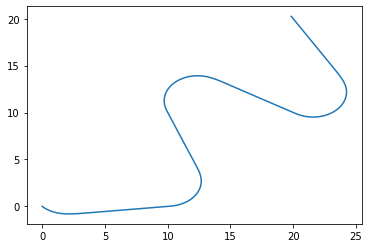

In [13]:
def localDemo():
    pathForSimulation = iter([
            [0, 0, 0],  #X, Y, orientation
            [10, 0, 0], #X, Y, orientation
            [10, 10, 0], #X, Y, orientation
            [0, 10, 0], #X, Y, orientation
            [0, 0, 0]
        ])

    pathForSimulation = iter([
            [0, 0, 0],  #X, Y, orientation
            [10, 0, 0], #X, Y, orientation
            [10, 10, 0], #X, Y, orientation
            [20, 10, 0], #X, Y, orientation
            [20, 20, 0]
        ])


    robotState0 = {
            'x': 0,
            'y': 0,
            'theta': -3.14 / 4
        }

    t0 = 0
    t_bound = 100
    max_step = 0.05

    state0 = None
    if robot == robotWithDynamic:
        state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0, 0, 0, 0, 0]) # x0=0, y0=0, theta
    else:
        state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0]) # x0=0, y0=0,theta

    solverfunc = simpleCompute(
        compute, state0 = state0, 
        t0 = t0, t_bound = t_bound, max_step = max_step)    

    controllerParams = {
        'gain': 4, 
        'omega_ri': 0, 
        'vri': 2.0, 
        'lowVelocityLimit': 0.2, 
        'highVelocityLimit': 2.0, 
        'lowOmegaLimit': -0.75, 
        'highOmegaLimit': 0.75
        }

    fullRobot = robotModelCreator(createCircleControllerWithGain, pathForSimulation, **controllerParams)      
    state1 = fullRobot(0, state0)
    robotStates = solverfunc(fullRobot)

    results = {}
    for key, selector in selectors.items():
        print(key)
        results[key] = []

    for currentState in robotStates: # readout all states from current moving robot
        for key, selector in selectors.items():
            results[key].append(selector(currentState))

    plt.plot(results['x'], results['y'])

if _runDemos:
    localDemo()

### Robins

In [14]:
def createController_By_RobinsMathew(k0, k1, omega_ri, vri, lowVelocityLimit, highVelocityLimit, lowOmegaLimit, highOmegaLimit):
    def controller(t, currentState, destinationState):
        currentX = currentState[0]
        currentY = currentState[1]
        currentTheta = currentState[2]

        destinationX = destinationState[0]
        destinationY = destinationState[1]

        cosTheta = cos(currentTheta)
        sinTheta = sin(currentTheta)
    
        deltaX = destinationX - currentX
        deltaY = destinationY - currentY
        theta_destination = atan2(deltaY, deltaX)
        theta_error = theta_destination - currentTheta

        Te = math.sin(theta_destination)*deltaX - math.cos(theta_destination)*deltaY
    
        velocity = vri*math.cos(theta_error)
        omega = omega_ri + k0*vri*Te + k1*vri*math.sin(theta_error)

        if velocity > highVelocityLimit:
            velocity = highVelocityLimit
        if (velocity < lowVelocityLimit):
            velocity = lowVelocityLimit
        if omega > highOmegaLimit:
            omega = highOmegaLimit
        if (omega < lowOmegaLimit):
            omega = lowOmegaLimit
      
        return velocity, omega
    return controller

### Fuzzy Logic Controller

#### Helper Functions

In [15]:
def createFuzzyfier(space, categories, trimf = fuzz.trimf, membership = fuzz.interp_membership):
    fuzzyInput = {}
    for key, value in categories.items():
        fuzzyInput[key] = trimf(space, value)
    def result(variable):
        output = {}
        for key, value in fuzzyInput.items():
            output[key] = membership(space, value, variable)
        if output[key] ==0:
            output[key] = 1e-5
        else:
            output[key] = output[key] 
        return output
    return result

def createInferenceSystem(inputAfuzzyfier, inputBfuzzyfier, outputSpace, outputDict, rulesDict, trimf = fuzz.trimf):
    fuzzyResults = {}
    for keyA, outerValue in rulesDict.items():
        if not(keyA in fuzzyResults):
            fuzzyResults[keyA] = {}
        for keyB, innerValue in outerValue.items():
            fuzzyResults[keyA][keyB] = trimf(outputSpace, outputDict[innerValue]) #innerValue==outputDict[keyA][keyB]
    def result(valueA, valueB):
        fuzzyVariableA = inputAfuzzyfier(valueA)
        fuzzyVariableB = inputBfuzzyfier(valueB)
        fuzzyResult = None
        for keyA, outerValue in rulesDict.items():
            for keyB, resultValue in outerValue.items():
                currentResult = np.fmin(fuzzyResults[keyA][keyB],
                    np.fmin(fuzzyVariableA[keyA], fuzzyVariableB[keyB]))
                if fuzzyResult is None:
                    fuzzyResult = currentResult
                else:
                    fuzzyResult = np.fmax(currentResult, fuzzyResult)
        return fuzzyResult
    return result

def createDefuzzyfier(outputSpace, *defuzzArgs, defuzz=fuzz.defuzz, **defuzzKwargs):
    def result(value):
        return defuzz(outputSpace, value, *defuzzArgs, **defuzzKwargs)
    return result
  
def createFullFuzzySystem(inferenceSystem, defuzzyfier):
    def system(inputA, inputB):
        return defuzzyfier(inferenceSystem(inputA, inputB))
    return system

#### Controller

In [16]:
def createFuzzyController(fuzzyDescription, r, b, omega_ri, vri, lowVelocityLimit, highVelocityLimit, lowOmegaLimit, highOmegaLimit):
    inputsDistance = fuzzyDescription['inputs']['distance']['M']
    inputsSpaceDistance = np.array(fuzzyDescription['inputs']['distance']['S'])
    
    inputsAngle = fuzzyDescription['inputs']['angle']['M']
    inputsSpaceAngle = np.array(fuzzyDescription['inputs']['angle']['S'])
    
    outputsOmegaR = fuzzyDescription['outputs']['omegaR']['M']
    outputSpaceOmegaR = np.array(fuzzyDescription['outputs']['omegaR']['S'])
    outputRulesOmegaR = fuzzyDescription['outputs']['omegaR']['rules']
    
    outputsOmegaL = fuzzyDescription['outputs']['omegaL']['M']
    outputSpaceOmegaL = np.array(fuzzyDescription['outputs']['omegaL']['S'])
    outputRulesOmegaL = fuzzyDescription['outputs']['omegaL']['rules']


    inputsDistanceFuzzyfier = createFuzzyfier(inputsSpaceDistance, inputsDistance)
    inputsAngleFuzzyfier = createFuzzyfier(inputsSpaceAngle, inputsAngle)

    inferenceSystem_R = createInferenceSystem(inputsDistanceFuzzyfier, inputsAngleFuzzyfier, outputSpaceOmegaR, outputsOmegaR, outputRulesOmegaR)
    outputDefuzzyfier_R = createDefuzzyfier(outputSpaceOmegaL, mode='centroid')

    inferenceSystem_L = createInferenceSystem(inputsDistanceFuzzyfier, inputsAngleFuzzyfier, outputSpaceOmegaL, outputsOmegaL, outputRulesOmegaL)
    outputDefuzzyfier_L = createDefuzzyfier(outputSpaceOmegaL, mode='centroid')

    fullSystem_R = createFullFuzzySystem(inferenceSystem_R, outputDefuzzyfier_R)
    fullSystem_L = createFullFuzzySystem(inferenceSystem_L, outputDefuzzyfier_L)
    
    def controller(t, currentState, destinationState):
        currentX = currentState[0]
        currentY = currentState[1]
        currentTheta = currentState[2]

        destinationX = destinationState[0]
        destinationY = destinationState[1]

        cosTheta = cos(currentTheta)
        sinTheta = sin(currentTheta)
        
        deltaX = destinationX - currentX
        deltaY = destinationY - currentY
        theta_destination = atan2(deltaY, deltaX)
        THETA_ERROR = theta_destination - currentTheta
        DISTANCE_ERROR = sqrt(deltaX * deltaX + deltaY * deltaY)
        
        if (THETA_ERROR > pi):
            THETA_ERROR -= 2*pi
        if (THETA_ERROR < -pi):
            THETA_ERROR += 2*pi
      
        omega_R = fullSystem_R(DISTANCE_ERROR, THETA_ERROR)
        omega_L = fullSystem_L(DISTANCE_ERROR, THETA_ERROR)

        velocity = r * (omega_R + omega_L) / 2
        omega = r * (omega_R - omega_L) / b

        if velocity > highVelocityLimit:
            velocity = highVelocityLimit
        if (velocity < lowVelocityLimit):
            velocity = lowVelocityLimit
        if omega > highOmegaLimit:
            omega = highOmegaLimit
        if (omega < lowOmegaLimit):
            omega = lowOmegaLimit

        return velocity, omega
    return controller

## Simulation Function

In next part the full description of simulation is stored in a single structured JSON document / variable. If this document is mutated, the slighly different condition for simulation are defined. Set of mutated documents and results of described simulations might be compared and thus proper results can be selected. This process creates a basement for optimization techniques.

### Simulation Description

In [17]:
simulationDescription = {

    'robotState0': {
        'x': 0,
        'y': 0,
        'theta': -3.14 / 4
    },

    'path': [
        [0, 0, 0],  #X, Y, orientation
        [10, 0, 0], #X, Y, orientation
        [10, 10, 0], #X, Y, orientation
        [0, 10, 0], #X, Y, orientation
        [0, 0, 0]
    ],

    'robotParams': {
        'r': 0.0925,
        'b': 0.37,
        'm': 9,
        'I': 0.16245,
        #'motorParams': None,
        'motorParams': {
            'J': 0.01,
            'B': 0.1,

            'Kt': 0.01,
            'Ke': 0.01,
            'K': 0.01,

            'Ra': 0.1,
            'La': 0.01
        }
    },
    
    'controllerParams': {
        'omega_ri': 0, 'vri': 2.0,'lowVelocityLimit': 0.2, 
        'highVelocityLimit': 2.0, 'lowOmegaLimit': -0.75, 'highOmegaLimit': 0.75
    },

    'simulationParams': {
        't0': 0,
        't_bound': 100,
        'max_step': 0.05
    }
}

### Executor

In [18]:
def runSimulation(simulationDescription, controllerCreator, selectors=selectors):
  
    pathForSimulation = iter(simulationDescription['path'])

    t0 = simulationDescription['simulationParams']['t0']
    t_bound = simulationDescription['simulationParams']['t_bound']
    max_step = simulationDescription['simulationParams']['max_step']

    state0 = None
    robotState0 = simulationDescription['robotState0']
    if robot == robotWithDynamic:
        state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0, 0, 0, 0, 0]) # x0=0, y0=0, theta
    else:
        state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0]) # x0=0, y0=0,theta

    solverfunc = simpleCompute(
        compute, state0 = state0, 
        t0 = t0, t_bound = t_bound, max_step = max_step)

    controllerParams = simulationDescription['controllerParams']
    completeRobot = robotModelCreator(controllerCreator, pathForSimulation, **controllerParams)      
    robotStates = solverfunc(completeRobot)

    results = {}
    for key, selector in selectors.items():
        results[key] = []

    for currentState in robotStates: # readout all states from current moving robot
        for key, selector in selectors.items():
            results[key].append(selector(currentState))

    return results

### Example of Use

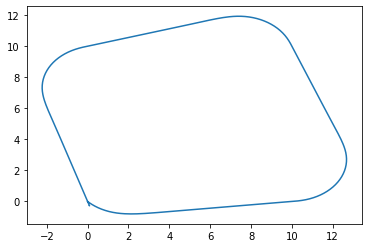

In [19]:
import copy

def localDemo():
    circleControllerDescription = copy.deepcopy(simulationDescription)
    circleControllerDescription['controllerParams']['gain'] = 4

    results = runSimulation(circleControllerDescription, createCircleControllerWithGain, selectors)
    plt.plot(results['x'], results['y'])
    
if _runDemos:
    localDemo()

## Chromozome Mapping Functions

These functions change standard simulation description into description based on information stored in chromosome. Also these functions could be named as a chromosome information decoder.

### Circle Controller

In [20]:
import copy
def fromChromozomeToDescriptionCircle(chromozome, description):
    result = copy.deepcopy(description)
    result['controllerParams']['gain'] = chromozome[0]
    return result

### Robins Controller

In [21]:
import copy
def fromChromozomeToDescriptionRobins(chromozome, description):
    result = copy.deepcopy(description)
    result['controllerParams']['k0'] = chromozome[0]
    result['controllerParams']['k1'] = chromozome[1]
    return result

### Fuzzy Logic Controller

In [22]:
import copy
def fromChromozomeToDescriptionFuzzy(chromozome, description):
    CH = chromozome # just for simplicity
    result = copy.deepcopy(description)

    fuzzyDescription = {
        'inputs': {
            'distance' : {
                'S': list(np.arange(0, 2, 0.02)),
                'M': {'VC': [0, 0, 0.5], 'C': [0, 0.5, 1], 'M': [0.5, 1, 1.5], 'F': [1, 1.5, 2], 'VF': [1.5, 2, 2]}
            },
            'angle' : {
                'S': list(np.arange(-3.14, 3.14, 0.0628)),
                'M': {'BN': [-3.14, -3.14, -1.57], 'N': [-3.14, -1.57, 0], 'Z': [-1.57, 0, 1.57], 'P': [0, 1.57, 3.14], 'BP': [1.57, 3.14, 3.14]}
            }
        },
        'outputs': {
            'omegaR': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'BN': 'VSR', 'N': 'SR', 'Z': 'VSR', 'P': 'BR', 'BP': 'VBR'},
                    'C': {'BN': 'VSR', 'N': 'SR', 'Z': 'SR', 'P': 'BR', 'BP': 'VBR'},
                    'M': {'BN': 'VSR', 'N': 'SR', 'Z': 'MBR', 'P': 'BR', 'BP': 'VBR'},
                    'F': {'BN': 'VSR', 'N': 'SR', 'Z': 'BR', 'P': 'BR', 'BP': 'VBR'},
                    'VF': {'BN': 'VSR', 'N': 'SR', 'Z': 'VBR', 'P': 'BR', 'BP': 'VBR'}
                },
                'mode': 'centroid',
                'M': {'VSR': [0, 0, 7.5], 'SR': [0, 7.5, 15], 'MBR': [7.5, 15, 22.5], 'BR': [15, 22.5, 30], 'VBR': [22.5, 30, 30]}
            },
            'omegaL': {
                'S': list(np.arange(0, 30, 0.3)),
                'rules': {
                    'VC': {'BN': 'VBL', 'N': 'BL', 'Z': 'VSL', 'P': 'SL', 'BP': 'VSL'},
                    'C': {'BN': 'VBL', 'N': 'BL', 'Z': 'SL', 'P': 'SL', 'BP': 'VSL'},
                    'M': {'BN': 'VBL', 'N': 'BL', 'Z': 'MBL', 'P': 'SL', 'BP': 'VSL'},
                    'F': {'BN': 'VBL', 'N': 'BL', 'Z': 'BL', 'P': 'SL', 'BP': 'VSL'},
                    'VF': {'BN': 'VBL', 'N': 'BL', 'Z': 'VBL', 'P': 'SL', 'BP': 'VSL'} 
                },
                'mode': 'centroid',
                'M': {'VSL': [0, 0, 7.5], 'SL': [0, 7.5, 15], 'MBL': [7.5, 15, 22.5], 'BL': [15, 22.5, 30], 'VBL': [22.5, 30, 30]}
            }
        }
    }     

    distance_Member = {'VC': [0, 0, CH[0]], 
                       'C': [CH[2] - CH[1], CH[2], CH[2] + CH[3]],
                       'M': [CH[5] - CH[4], CH[5], CH[5] + CH[6]],
                       'F': [CH[8] - CH[7], CH[8], CH[8] + CH[9]], 
                       'VF': [2 - CH[10], 2, 2]}
    fuzzyDescription['inputs']['distance']['M'] = distance_Member

    angle_Member = {'BN': [-3.14, -3.14, -3.14+CH[11]], 
                    'N': [CH[13] - CH[12], CH[13], CH[13] + CH[14]],
                    'Z': [CH[16] - CH[15], CH[16], CH[16] + CH[17]], 
                    'P': [CH[19] - CH[18], CH[19], CH[19] + CH[20]], 
                    'BP': [3.14 - CH[21], 3.14, 3.14]}    
    fuzzyDescription['inputs']['angle']['M'] = angle_Member

    omegaR_Member =  {'VSR': [0, 0, CH[22]], 
                      'SR': [CH[24] - CH[23], CH[24], CH[24] + CH[25]],
                      'MBR': [CH[27] - CH[26], CH[27], CH[27] + CH[28]], 
                      'BR': [CH[30] - CH[29], CH[30], CH[30] + CH[31]], 
                      'VBR': [30 - CH[32], 30, 30]}
    fuzzyDescription['outputs']['omegaR']['M'] = omegaR_Member

    omegaL_Member =  {'VSL': [0, 0, CH[33]], 
                      'SL': [CH[35] - CH[34], CH[35], CH[35] + CH[36]],
                      'MBL': [CH[38] - CH[37], CH[38], CH[38] + CH[39]], 
                      'BL': [CH[41] - CH[40], CH[41], CH[41] + CH[42]], 
                      'VBL': [30 - CH[43], 30, 30]}
    fuzzyDescription['outputs']['omegaL']['M'] = omegaL_Member

    result['controllerParams']['fuzzyDescription'] = fuzzyDescription
    
    result['controllerParams']['r'] = result['robotParams']['r']
    result['controllerParams']['b'] = result['robotParams']['b']
    return result

#### Demo of Use

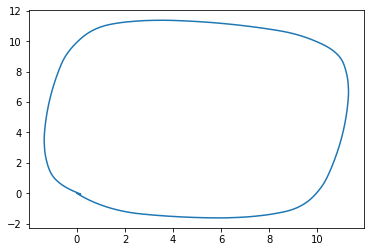

In [23]:
def localDemo():
    _chromosome = [ 1.74005451,  1.48015509,  0.11228583,  1.09902842,  0.43416075,  1.12959802,
      0.79451062,  0.35309807,  1.89647492,  0.8603056,   1.31815441,  3.50991593,
      1.26617812, -1.53443539,  4.50231413,  5.05053392, -0.57660657,  0.09952368,
      5.86490838,  2.82272312,  4.57718351,  5.83371728, 21.28833523,  5.04601735,
      6.78410773, 23.10967576,  3.59687006, 15.67996143, 12.05597772, 21.35955841,
     18.03735429,  5.93796649, 11.40657898, 14.15564325, 27.64321413,  9.5777817,
      9.06290194, 26.49085526, 15.25899858, 17.25071225,  4.15064069, 27.54360651,
     18.41613269,  9.71691383]

    fuzzyLogicSimulationDescription = fromChromozomeToDescriptionFuzzy(_chromosome, simulationDescription)
    results = runSimulation(fuzzyLogicSimulationDescription, createFuzzyController, selectors=selectors)

    plt.plot(results['x'], results['y'])
    
if _runDemos:
    localDemo()

## Path Mapping Function

This function allows to easy change simulation description for path which a robot has to follow.

In [24]:
import copy
def fromPathToDescription(path, description):
    result = copy.deepcopy(description)
    result['path'] = list(path)
    return result

## Fitness Functions (Based on Chromozomes)

For optimization the fitness functions are needed. The simulation function has been defined earlier in this document. A fitness function must transform chromozome into simulation description, run appropriate simulation and return all results or subset of results. This chapter defines a bunch of fitness functions.

### Helper Functions

#### Function for Fitness Function Creation

```createFitnessFunction``` allows to create fitness function which is appropriate for description, chromosome decoder (```mapperFunction```), function which creates controller (```controllerCreator```) and, if needed, selection of subresult (```resultSelector```).

In [25]:
def createFitnessFunction(baseDescription, mapperFunction, controllerCreator, resultSelector=lambda item: item):
    def fitnessFunction(chromozome):
        freshDescription = mapperFunction(chromozome, baseDescription)
        results = runSimulation(freshDescription, controllerCreator, selectors=selectors)
        result = resultSelector(results)
        return result
    return fitnessFunction

In [26]:
def energySelector(results):
    return results['E'][-1]

In [27]:
def distanceSelector(results):
    return results['d'][-1]

#### Multivalue Functions

```singleAsMultiValue``` transforms function with scalar value into function with vector value. Such transformation creates a functionc which can evaluate multiple values in single call.

In [28]:
def singleAsMultiValue(singleFunction):
    def resultFunction(chromosomes):
        results = []
        for chromosome in chromosomes:
            results.append(singleFunction(chromosome))
        return results
    return resultFunction

### Simulation Description

From this point simulations depend on ```simulationDescription``` defined in next code. Thus if any change is needed this is best place for it.

In [29]:
simulationDescription = {
    'robotState0': {
        'x': 0,
        'y': 0,
        'theta': -3.14 / 4
    },

    'path': [
        [0, 0, 0],  #X, Y, orientation
        [10, 0, 0], #X, Y, orientation
        [10, 10, 0], #X, Y, orientation
        [0, 10, 0], #X, Y, orientation
        [0, 0, 0]
    ],

    'robotParams': {
        'r': 0.0925,
        'b': 0.37,
        'm': 9,
        'I': 0.16245,
        #'motorParams': None,
        'motorParams': {
            'J': 0.01,
            'B': 0.1,

            'Kt': 0.01,
            'Ke': 0.01,
            'K': 0.01,

            'Ra': 0.1,
            'La': 0.01
        }
    },
    
    'controllerParams': {
        'omega_ri': 0, 'vri': 2.0,'lowVelocityLimit': 0.2, 
        'highVelocityLimit': 2.0, 'lowOmegaLimit': -0.75, 'highOmegaLimit': 0.75
    },

    'simulationParams': {
        't0': 0,
        't_bound': 100,
        'max_step': 0.05
    }
}

### Fuzzy Logic Controller

#### Singlevalue Functions

In [30]:
fitnessFunctionFLC_Energy = createFitnessFunction(simulationDescription, fromChromozomeToDescriptionFuzzy, createFuzzyController, energySelector)
fitnessFunctionFLC_Distance = createFitnessFunction(simulationDescription, fromChromozomeToDescriptionFuzzy, createFuzzyController, distanceSelector)
fitnessFunctionFLC_FullResults = createFitnessFunction(simulationDescription, fromChromozomeToDescriptionFuzzy, createFuzzyController)

#### Multivalue Functions

In [31]:
fitnessFunctionFLC_EnergyMulti = singleAsMultiValue(fitnessFunctionFLC_Energy)
fitnessFunctionFLC_DistanceMulti = singleAsMultiValue(fitnessFunctionFLC_Distance)
fitnessFunctionFLC_FullResultsMulti = singleAsMultiValue(fitnessFunctionFLC_FullResults)

### Circle

#### Singlevalue Functions

In [32]:
fitnessFunctionCircle_Energy = createFitnessFunction(simulationDescription, fromChromozomeToDescriptionCircle, createCircleControllerWithGain, energySelector)
fitnessFunctionCircle_Distance = createFitnessFunction(simulationDescription, fromChromozomeToDescriptionCircle, createCircleControllerWithGain, distanceSelector)
fitnessFunctionCircle_FullResults = createFitnessFunction(simulationDescription, fromChromozomeToDescriptionCircle, createCircleControllerWithGain)

#### Multivalue Functions

In [33]:
fitnessFunctionCircle_EnergyMulti = singleAsMultiValue(fitnessFunctionCircle_Energy)
fitnessFunctionCircle_DistanceMulti = singleAsMultiValue(fitnessFunctionCircle_Distance)
fitnessFunctionCircle_FullResultsMulti = singleAsMultiValue(fitnessFunctionCircle_FullResults)

#### Demonstration

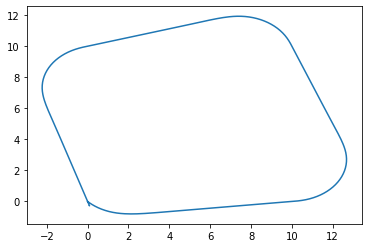

In [34]:
def localDemo():
    results = fitnessFunctionCircle_FullResults([4])
    #print(results)
    plt.plot(results['x'], results['y'])
    
if _runDemos:
    localDemo()

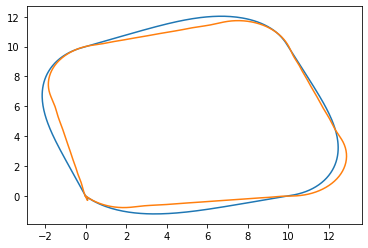

In [35]:
def localDemo():
    results = fitnessFunctionCircle_FullResultsMulti([[2], [16]])
    plt.plot(results[0]['x'], results[0]['y'])
    plt.plot(results[1]['x'], results[1]['y'])
    
if _runDemos:
    localDemo()

### Robins

#### Singlevalue Functions

In [36]:
fitnessFunctionRobins_Energy = createFitnessFunction(simulationDescription, fromChromozomeToDescriptionCircle, createCircleControllerWithGain, energySelector)
fitnessFunctionRobins_Distance = createFitnessFunction(simulationDescription, fromChromozomeToDescriptionCircle, createCircleControllerWithGain, distanceSelector)
fitnessFunctionRobins_FullResults = createFitnessFunction(simulationDescription, fromChromozomeToDescriptionCircle, createCircleControllerWithGain)

#### Multivalue Functions

In [37]:
fitnessFunctionRobins_EnergyMulti = singleAsMultiValue(fitnessFunctionRobins_Energy)
fitnessFunctionRobins_DistanceMulti = singleAsMultiValue(fitnessFunctionRobins_Distance)
fitnessFunctionRobins_FullResultsMulti = singleAsMultiValue(fitnessFunctionRobins_FullResults)

## Computer Cluster Help

Multivalue fitness function is function which takes an array of chromozomes and returns another array containing the fitness values for all given chromozomes. Body of a such function could be implemented as a parallel process which decrease time needed for its evaluation.

The parallel process might be implemented in different ways. One of them, and probably the best one, is usage of distributed evaluation with help of computer cluster. Computer cluster creation is well-documented process with standard steps, thus, a scientist who want to use this technique must just define single environment, environment for evaluation of single fitness function. 

As an envelope around this environment the web service might be used. However, this leads to asynchronous execution. As the optimization libraries for Python are synchronous, the connection between asynchronous and synchronous parts must be created.

### Main Function for Server

In [38]:
def evaluateSingleFLCSimulation(description):
    results = runSimulation(description, createFuzzyController, selectors)
    return result

### Async as Sync

For ability to evaluate set of simulations in parallel async functions should be used and maintaned. For optimization algorithms this must be callable for synchronous environment and thus a conversion from async to sync must be done.

In [39]:
import asyncio
import threading
#----------------------------------------
# upgraded from https://stackoverflow.com/questions/49330905/how-to-run-a-coroutine-and-wait-it-result-from-a-sync-func-when-the-loop-is-runn
#----------------------------------------

def evalSet(asyncTask, values):
    loop = asyncio.new_event_loop() # construct a new event loop

    def run_forever_safe(loop):
        loop.run_forever()
        # for Python 3.7 and newer
        # loop_tasks_all = asyncio.all_tasks(loop=loop)
        # for Python 3.6
        loop_tasks_all = asyncio.Task.all_tasks(loop=loop)

        for task in loop_tasks_all: 
            task.cancel()

        for task in loop_tasks_all:
            if not (task.done() or task.cancelled()):
                try:
                    # wait for task cancellations
                    loop.run_until_complete(task)
                except asyncio.CancelledError: pass

        loop.close()
    
    def stop_loop(loop):
        ''' stops an event loop '''
        loop.stop()
        #print (".:) LOOP STOPPED:", loop.is_running())
        
    def await_sync(task):
        ''' synchronously waits for a task '''
        while not task.done(): 
            pass
        #print(".: AWAITED TASK DONE")
        return task.result()
    
    #-- closures for running and stopping the event-loop
    run_loop_forever = lambda: run_forever_safe(loop)
    close_loop_safe = lambda: loop.call_soon_threadsafe(stop_loop, loop)
    
    #-- make dedicated thread for running the event loop
    thread = threading.Thread(target=run_loop_forever)

    #-- add some tasks along with my particular task
    evaluationTasks = [asyncio.run_coroutine_threadsafe(asyncTask(value), loop=loop) for value in values]

    #-- begin the thread to run the event-loop
    thread.start()

    #-- _synchronously_ wait for the result of my task
    results = [await_sync(task) for task in evaluationTasks]

    # close the loop gracefully when everything is finished
    close_loop_safe()
    thread.join()
    return results
#----------------------------------------

### Webservice Usage

In [40]:
!pip install aiohttp

     |████████████████████████████████| 1.3MB 6.2MB/s 
     |████████████████████████████████| 296kB 16.0MB/s 
     |████████████████████████████████| 143kB 21.5MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3163 sha256=cf0bf68447a0b6b1c0992629fbcf69aad0d05973999c7087b5ec30286a69e5de
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl


In [41]:
import time
def mS(start = 0):
    return int(round(time.time() * 1000)) - start

This part encapsules a remote fitness function evaluator. Parameter describes fully the simulation thus a remote evaluator does not make any conversion, just run the described simulation and returns the results.

This function is crucial in use of computer cluster. Also this is a point where the evaluation could be redirected to proper sources.

In [42]:
import aiohttp
import asyncio

url = 'https://ourserver/api/evaluator/FFFF' # you must replace our URL address (which was unable to run) with your one.
async def fitnessFunctionAsWebservice(value):
    #async with aiohttp.ClientSession() as session:
    async with aiohttp.ClientSession(connector=aiohttp.TCPConnector(ssl=False)) as session:
        response = await session.post(url, json=value, headers = {'content-type': 'application/x-json'})
        json_body = await response.json()
    return json_body

In [43]:
def callResultsFLC():
    sTime = mS()        
    results = evalSet(fitnessFunctionAsWebservice, [fitnessFunctionDescription])
    return results

### Remote / Cluster Fitness Function Evaluation

In [44]:
def fitnessFunctionFLC_FullMultiRemote(chromosomes):
    descriptions = []
    for chromosome in chromosomes:
        description = fromChromozomeToDescriptionFuzzy(simulationDescription, chromosome)
        descriptions.append(description)

    # Pythonic way:
    # descriptions = [fromChromozomeToDescriptionFuzzy(simulationDescription, chromosome) for chromosome in chromosomes]
        
    results = evalSet(fitnessFunctionAsWebservice, descriptions)
    return results

def fitnessFunctionFLC_EnergyMultiRemote(chromosomes):
    results = fitnessFunctionFLC_FullMultiRemote(chromosomes)
    
    selectedResults = []
    for result in results:
        selectedResults.append(result['E'])

    # Pythonic way:
    # selectedResults = [result['E'] for result in results]

    return selectedResults

def fitnessFunctionFLC_DistanceMultiRemote(chromosomes):
    results = fitnessFunctionFLC_FullMultiRemote(chromosomes)

    selectedResults = []
    for result in results:
        selectedResults.append(result['E'])
    return selectedResults

### Decision about Cluster Use

In [45]:
if useCluster:
    # TODO, redefine for cluster use
    fitnessFunctionFLC_EnergyMulti = singleAsMultiValue(fitnessFunctionFLC_Energy)
    fitnessFunctionFLC_DistanceMulti = singleAsMultiValue(fitnessFunctionFLC_Distance)
    fitnessFunctionFLC_FullResultsMulti = singleAsMultiValue(fitnessFunctionFLC_FullResults)  
    pass

## Optimization

### Inevitable Imports

In [46]:
!pip install pymoo

     |████████████████████████████████| 3.7MB 5.3MB/s 
     |████████████████████████████████| 245kB 40.9MB/s 
  Created wheel for pymoo: filename=pymoo-0.4.2.1-cp36-cp36m-linux_x86_64.whl size=1344723 sha256=c0edf1f3fb9b41cb7911188b75b49d4018a65fcfbca051226cf76d2f1113884c
  Stored in directory: /root/.cache/pip/wheels/24/1a/15/c95ef6c978305899c8b374fd3a36dd494a46a63b2b32c6c5c5
Successfully built pymoo


In [47]:
import time
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.model.problem import Problem
from pymoo.optimize import minimize
from pymoo.factory import get_termination
from pymoo.visualization.scatter import Scatter

### Formal Problem Description

In [48]:

# TODO, proper formating
problemParametersSetA = [0, 0, 0, 0, 0, 0.75, 0, 0, 1.25, 0, 0,       0, 0, -3.14, 0, 0, -1, 0, 0, 1, 0, 0]
problemParametersSetB = [0, 0, 0, 0, 0, 12, 0, 0, 18, 0, 0,           0, 0, 0, 0, 0, 12, 0, 0, 18, 0, 0]
chromosomeFLCLow = [*problemParametersSetA, *problemParametersSetB]

problemParametersSetC = [2, 2, 0.75, 2, 2, 1.25, 2, 2, 2, 2, 2,       6.28, 6.28, -1, 6.28, 6.28, 1, 6.28, 6.28, 3.14, 6.28, 6.28]
problemParametersSetD = [30, 30, 12, 30, 30, 18, 30, 30, 30, 30, 30,  30, 30, 12, 30, 30, 18, 30, 30, 30, 30, 30]
chromosomeFLCUp = [*problemParametersSetC, *problemParametersSetD]

runElementWiseEvaluation = True
class MyProblem(Problem):
    def __init__(self):
        self.SpecialCounter = 0
        super().__init__(n_var=44,
                         n_obj=1,
                         n_constr=1,
                         xl=np.array([*problemParametersSetA, *problemParametersSetB]),
                         xu=np.array([*problemParametersSetC, *problemParametersSetD]),
                         elementwise_evaluation=runElementWiseEvaluation)
    def _evaluate(self, Chromosome, out, *args, **kwargs):
        self.SpecialCounter = self.SpecialCounter + 1
        if self.SpecialCounter >= 99:
            print()
            self.SpecialCounter = 0
        print('.', end='')
        try:
            if runElementWiseEvaluation:
                allResults = fitnessFunctionFLC_FullResults(Chromosome)
                f1 = energySelector(allResults) # used to evaluate the energy consum#tion
                g1 = distanceSelector(allResults) - 50
            else:
                allResults = fitnessFunctionFLC_FullResultsMulti(Chromosome)
                f1 = [energySelector(result) for result in allResults] # used to evaluate the energy consum#tion
                g1 = [distanceSelector(result) - 50 for result in allResults]
            #f2 = distance_fitnessFuntion_for_GA(Chromosome) # used to evaluate the travel ditance
            #g1 = fitnessFunctionFLC_DistanceMulti(Chromosome) - 50 # is constraint used for tracking the path, because when s > 50 the Robot will loss the path.
            out["F"] = f1
            out["G"] = g1
        except:
            print(Chromosome)

### Optimization Problem Solution

In [49]:
start_time = time.time()
problem = MyProblem()
algorithm = NSGA2(pop_size=50)

'''
algorithm = NSGA2(
    pop_size=50,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
)
'''
termination = get_termination("n_gen", 5)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

print("Best solution found: \nBest_Chromosome = %s\nOptimal E = %s" % (res.X, res.F))
print("Time required in second = %s" % (time.time() - start_time))

if  1 < len(res.X) < 30:
  Best_Chromosome = res.X[0]
else:
  Best_Chromosome = res.X

..................................................=====================================================================================
n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |      50 |  6.98615E+01 |  8.92245E+01 |       1 |            - |            -
................................................
..    2 |     100 |  6.67957E+01 |  8.26651E+01 |       1 |  1.46832E+01 |        ideal
..................................................    3 |     150 |  0.00000E+00 |  7.78504E+01 |       1 |  8.90647E+01 |        ideal
...............................................
...    4 |     200 |  0.00000E+00 |  6.86685E+01 |       1 |  6.42391E+01 |        ideal
..................................................    5 |     250 |  0.00000E+00 |  5.85231E+01 |       1 |  0.00000E+00 |            f
Best solution found: 
Best_Chromosome = [ 3.26177125e-01  3.30225739e-01  9.39627655e-02  1.14760574e+00
  1.70771732e+00  8.72317033e-01  1.47138

## Results Analysys

In [51]:
selectx = lambda item: item['y'][0]       # x position
selecty = lambda item: item['y'][1]       # y position
selectt = lambda item: item['time']       # time
selectv = lambda item: item['dy'][3]      # velocity
selectomega = lambda item: item['dy'][2]  # omega = theta_dot
selecte = lambda item: item['TotalEnergy']# total energy
selects = lambda item: item['y'][3]       # displacement
selectors = {
    'time': selectt,
    'x': selectx, 
    'y': selecty, 
    'd': selects, 
    'v': selectv, 
    'omega': selectomega,
    'E': selecte}

In [52]:
simulationDescription = {
    'robotState0': {
        'x': 0,
        'y': 0,
        'theta': -3.14 / 4
    },

    'path': [
        [0, 0, 0],  #X, Y, orientation
        [10, 0, 0], #X, Y, orientation
        [10, 10, 0], #X, Y, orientation
        [0, 10, 0], #X, Y, orientation
        [0, 0, 0]
    ],

    'robotParams': {
        'r': 0.0925,
        'b': 0.37,
        'm': 9,
        'I': 0.16245,
        #'motorParams': None,
        'motorParams': {
            'J': 0.01,
            'B': 0.1,

            'Kt': 0.01,
            'Ke': 0.01,
            'K': 0.01,

            'Ra': 0.1,
            'La': 0.01
        }
    },
    
    'controllerParams': {
        'omega_ri': 0, 'vri': 2.0,'lowVelocityLimit': 0.2, 
        'highVelocityLimit': 2.0, 'lowOmegaLimit': -0.75, 'highOmegaLimit': 0.75
    },

    'simulationParams': {
        't0': 0,
        't_bound': 100,
        'max_step': 0.05
    }
}

In [61]:
path = [
        [0, 0, 0],  #X, Y, orientation
        [10, 0, 0], #X, Y, orientation
        [10, 10, 0], #X, Y, orientation
        [0, 10, 0], #X, Y, orientation
        [0, 0, 0]
    ]

pathX = [point[0] for point in path]
pathY = [point[1] for point in path]

FLCChromosome = Best_Chromosome

# simulationDescription updated to path
simulationDescription = fromPathToDescription(path, simulationDescription)
simulationDescription['simulationParams']['t_bound'] = 40

# descriptions for simulations
FLCSimDescription = fromChromozomeToDescriptionFuzzy(FLCChromosome, simulationDescription)
RobinDescription = fromChromozomeToDescriptionRobins([1, 1], simulationDescription)
CircleDescription = fromChromozomeToDescriptionCircle([4], simulationDescription)

FLCFullResults = runSimulation(FLCSimDescription, createFuzzyController, selectors=selectors)
RobinFullResults = runSimulation(RobinDescription, createController_By_RobinsMathew, selectors=selectors)
CircleFullResults = runSimulation(CircleDescription, createCircleControllerWithGain, selectors=selectors)


Text(0, 0.5, '$E[J]$')

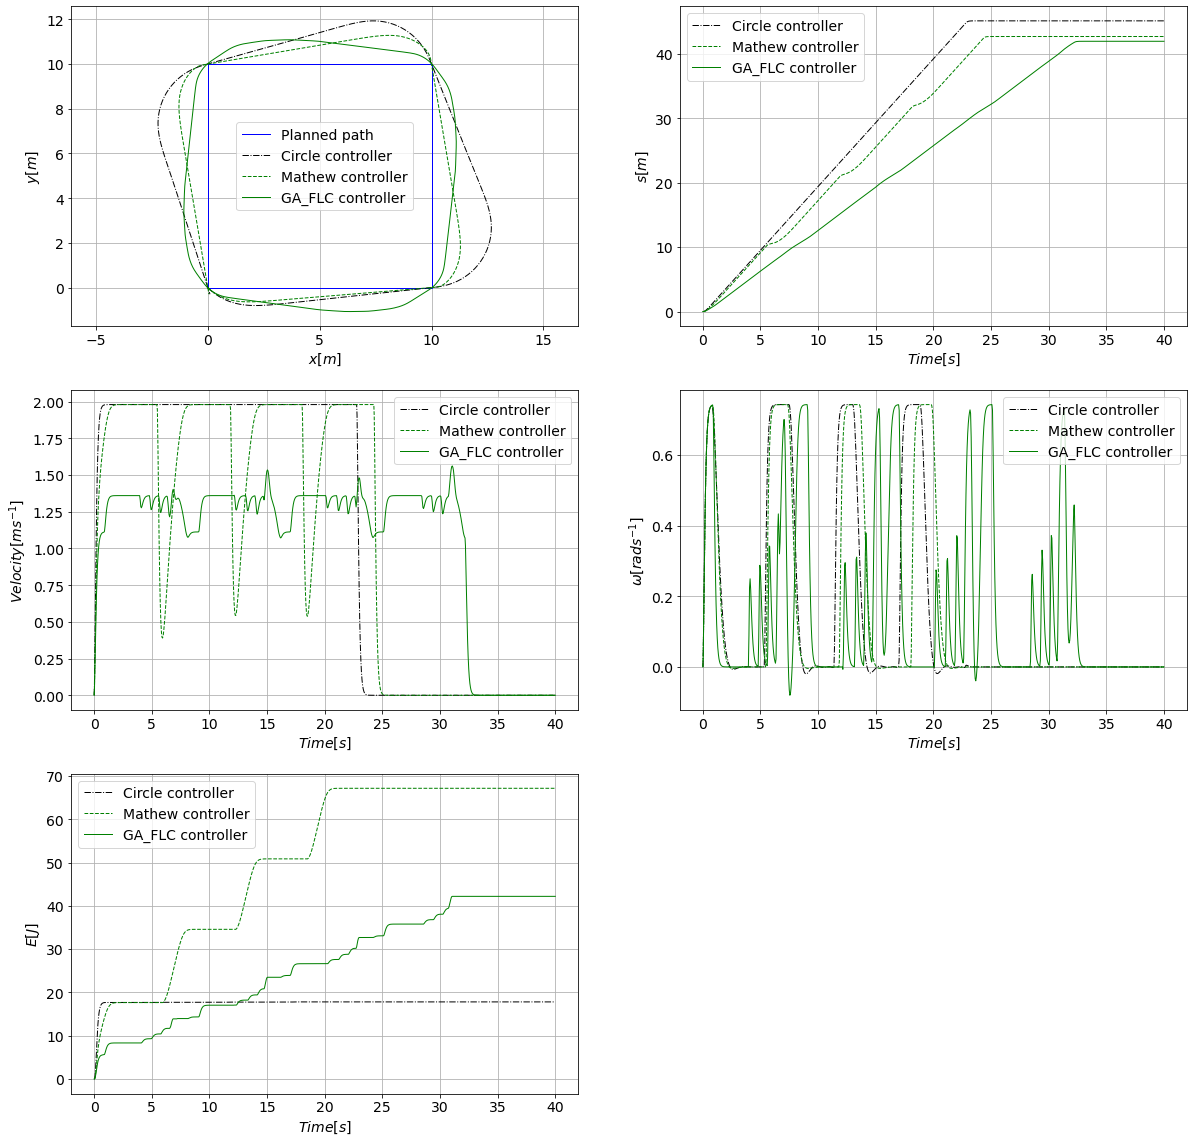

In [62]:
plt.rcParams["figure.figsize"] = (20, 20)
plt.rcParams["font.size"] = "14"

def multiPlot(xs, ys, styles, labels):
    for x, y, style, label in zip(xs, ys, styles, labels):
        plt.plot(x, y, style, label=label, lw=1)

#--plot the path--------------------------------------------------------------
plt.subplot(3,2,1)
plt.grid(which = 'both') 
p = plt.axis('equal')

multiPlot(
    [pathX, CircleFullResults['x'], RobinFullResults['x'], FLCFullResults['x']],
    [pathY, CircleFullResults['y'], RobinFullResults['y'], FLCFullResults['y']],
    ['b-', 'k-.', 'g--', 'g-', 'r-'],
    ['Planned path', 'Circle controller', 'Mathew controller', 'GA_FLC controller', 'Fuzzy controller']
    )

#plt.plot(pathx, pathy, 'b-', label = 'Planned path', lw = 1)
#plt.plot(x_Cir, y_Cir, 'k-.', label = 'Circle controller', lw = 1)
#plt.plot(x_Mathew, y_Mathew, 'g--', label = 'Mathew controller', lw = 1)
#plt.plot(x_Fuzzy, y_Fuzzy, 'r-', label = 'Fuzzy controller', lw = 1)
#plt.plot(x_Fuzzy_GA, y_Fuzzy_GA, 'g-', label = 'GA_FLC controller', lw = 1)
plt.legend(loc = 'best')
plt.xlabel('$x[m]$')
plt.ylabel('$y[m]$')

#def plotVal(n, t1, t2, t3, t4, val1, val2, val3, val4, lable):
#  plt.subplot(3,2,n)
#  plt.grid(which = 'both') 
#  plt.plot(t1, val1, 'r-', label = 'Fuzzy controller', lw = 1)
#  plt.plot(t2, val2, 'g-', label = 'GA_FLC controller', lw = 1)
#  plt.plot(t3, val3, 'k-.', label = 'Circle controller', lw = 1)
#  plt.plot(t4, val4, 'g--', label = 'Mathew controller', lw = 1)
#  plt.legend(loc = 'best')
#  plt.xlabel('$Time[s]$')
#  plt.ylabel(lable)
#  return

#--plot the travel distance----------------------------------------------------
#plotVal(2,time_Fuzzy,time_Fuzzy_GA,time_Cir,time_Mathew,s_Fuzzy,s_Fuzzy_GA,s_Cir,s_Mathew,'$s[m]$')

plt.subplot(3, 2, 2)
plt.grid(which = 'both') 
multiPlot(
    [CircleFullResults['time'], RobinFullResults['time'], FLCFullResults['time']],
    [CircleFullResults['d'], RobinFullResults['d'], FLCFullResults['d']],
    ['k-.', 'g--', 'g-', 'r-'],
    ['Circle controller', 'Mathew controller', 'GA_FLC controller', 'Fuzzy controller']
    )
plt.legend(loc = 'best')
plt.xlabel('$Time[s]$')
plt.ylabel('$s[m]$')


#---plot the velocity----------------------------------------------------------
#plotVal(3,time_Fuzzy,time_Fuzzy_GA,time_Cir,time_Mathew,velocity_Fuzzy,velocity_Fuzzy_GA,velocity_Cir,velocity_Mathew,'$Velocity[ms^{-1}]$')

plt.subplot(3, 2, 3)
plt.grid(which = 'both') 
multiPlot(
    [CircleFullResults['time'], RobinFullResults['time'], FLCFullResults['time']],
    [CircleFullResults['v'], RobinFullResults['v'], FLCFullResults['v']],
    ['k-.', 'g--', 'g-', 'r-'],
    ['Circle controller', 'Mathew controller', 'GA_FLC controller', 'Fuzzy controller']
    )
plt.legend(loc = 'best')
plt.xlabel('$Time[s]$')
plt.ylabel('$Velocity[ms^{-1}]$')

#--plot the omega-------------------------------------------------------------
#plotVal(4,time_Fuzzy,time_Fuzzy_GA,time_Cir,time_Mathew,omega_Fuzzy,omega_Fuzzy_GA,omega_Cir,omega_Mathew,'$Omega[rads^{-1}]$')

plt.subplot(3, 2, 4)
plt.grid(which = 'both') 
multiPlot(
    [CircleFullResults['time'], RobinFullResults['time'], FLCFullResults['time']],
    [CircleFullResults['omega'], RobinFullResults['omega'], FLCFullResults['omega']],
    ['k-.', 'g--', 'g-', 'r-'],
    ['Circle controller', 'Mathew controller', 'GA_FLC controller', 'Fuzzy controller']
    )
plt.legend(loc = 'best')
plt.xlabel('$Time[s]$')
plt.ylabel('$\omega[rads^{-1}]$')

#--plot the total energy consumption------------------------------------------
#plotVal(5,time_Fuzzy,time_Fuzzy_GA,time_Cir,time_Mathew,E_Fuzzy,E_Fuzzy_GA,E_Cir,E_Mathew,'$E[J]$')

plt.subplot(3, 2, 5)
plt.grid(which = 'both') 
multiPlot(
    [CircleFullResults['time'], RobinFullResults['time'], FLCFullResults['time']],
    [CircleFullResults['E'], RobinFullResults['E'], FLCFullResults['E']],
    ['k-.', 'g--', 'g-', 'r-'],
    ['Circle controller', 'Mathew controller', 'GA_FLC controller', 'Fuzzy controller']
    )
plt.legend(loc = 'best')
plt.xlabel('$Time[s]$')
plt.ylabel('$E[J]$')


In [ ]:
"""
Best_Chromosome = [ 1.08596739  1.71943383  0.10290456  0.74205663  0.52480311  0.89630788
  0.97332656  0.49053057  1.59783968  0.52701644  1.94705078  3.57292833
  1.29303852 -2.21474816  2.51256456  4.84639207 -0.50988046  0.11647957
  5.91902803  1.53442386  4.57658633  3.36543855 16.6810501  18.73199996
 11.28384463 21.67514579 18.66937586 13.39016815 11.33314493  2.78553134
 24.02750434  4.38830997 17.35999008  6.8961356  18.88797336  8.27900876
 15.72556844 19.72564223 16.1251766   8.20169371 18.31910936 23.4014107
 18.37933225  5.90972708]
OptimalE = [34.21738682]
"""

time
x
y
d
v
omega
E


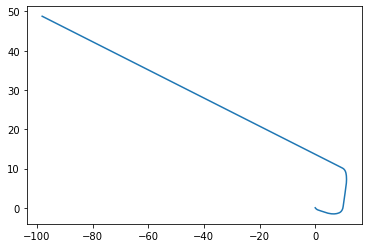

In [ ]:
_chromosome = [ 1.08596739,  1.71943383,  0.10290456,  0.74205663,  0.52480311,  0.89630788,
  0.97332656,  0.49053057,  1.59783968,  0.52701644,  1.94705078,  3.57292833,
  1.29303852, -2.21474816,  2.51256456,  4.84639207, -0.50988046,  0.11647957,
  5.91902803,  1.53442386,  4.57658633,  3.36543855, 16.6810501,  18.73199996,
 11.28384463, 21.67514579, 18.66937586, 13.39016815, 11.33314493,  2.78553134,
 24.02750434,  4.38830997, 17.35999008,  6.8961356,  18.88797336,  8.27900876,
 15.72556844, 19.72564223, 16.1251766,   8.20169371, 18.31910936, 23.4014107,
 18.37933225,  5.90972708]

pathForSimulation = iter([
        [0, 0, 0],  #X, Y, orientation
        [10, 0, 0], #X, Y, orientation
        [10, 10, 0], #X, Y, orientation
        [0, 10, 0], #X, Y, orientation
        [0, 0, 0]
    ])

pathForSimulation = iter([
        [0, 0, 0],  #X, Y, orientation
        [10, 0, 0], #X, Y, orientation
        [10, 10, 0], #X, Y, orientation
        [20, 10, 0], #X, Y, orientation
        [20, 20, 0]
    ])


robotState0 = {
        'x': 0,
        'y': 0,
        'theta': -3.14 / 4
    }

t0 = 0
t_bound = 100
max_step = 0.05

state0 = None
if robot == robotWithDynamic:
    state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0, 0, 0, 0, 0]) # x0=0, y0=0, theta
else:
    state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0]) # x0=0, y0=0,theta

solverfunc = simpleCompute(
    compute, state0 = state0, 
    t0 = t0, t_bound = t_bound, max_step = max_step)    

controllerParams = fromChromozomeToDescriptionFuzzy(_chromosome, fitnessFunctionDescription)['controllerParams']

fullRobot = robotModelCreator(createFuzzyController, pathForSimulation, **controllerParams)      
state1 = fullRobot(0, state0)
robotStates = solverfunc(fullRobot)

results = {}
for key, selector in selectors.items():
  print(key)
  results[key] = []

for currentState in robotStates: # readout all states from current moving robot
  for key, selector in selectors.items():
    results[key].append(selector(currentState))

plt.plot(results['x'], results['y'])

# STOP HERE

# Rest of Document

### Mapping from Chromozome to Simulation Description

This function changes standard simulation description into description based on informations stored in chromosome. Also this function could be named as a chromosome information decoder.

In [ ]:
def update_fitnessFunctionDescription(fitnessFunctionDescription, Chromosome):
    CH = Chromosome # just for simplicity
    result = {**fitnessFunctionDescription}

    distance_Member = {'VC': [0, 0, CH[0]], 
                       'C': [CH[2]-CH[1], CH[2], CH[2]+CH[3]],
                       'M': [CH[5]-CH[4], CH[5], CH[5]+CH[6]],
                       'F': [CH[8]-CH[7], CH[8], CH[8]+CH[9]], 
                       'VF': [2-CH[10], 2, 2]}
    result['fuzzyDescription']['inputs']['distance']['M'] = distance_Member

    angle_Member = {'BN': [-3.14, -3.14, -3.14+CH[11]], 
                    'N': [CH[13]-CH[12], CH[13], CH[13]+CH[14]],
                    'Z': [CH[16]-CH[15], CH[16], CH[16]+CH[17]], 
                    'P': [CH[19]-CH[18], CH[19], CH[19]+CH[20]], 
                    'BP': [3.14-CH[21], 3.14, 3.14]}    
    result['fuzzyDescription']['inputs']['angle']['M'] = angle_Member

    omegaR_Member =  {'VSR': [0, 0, CH[22]], 
                      'SR': [CH[24]-CH[23], CH[24], CH[24]+CH[25]],
                      'MBR': [CH[27]-CH[26], CH[27], CH[27]+CH[28]], 
                      'BR': [CH[30]-CH[29], CH[30], CH[30]+CH[31]], 
                      'VBR': [30-CH[32], 30, 30]}
    result['fuzzyDescription']['outputs']['omegaR']['M'] = omegaR_Member

    omegaL_Member =  {'VSL': [0, 0, CH[33]], 
                      'SL': [CH[35]-CH[34], CH[35], CH[35]+CH[36]],
                      'MBL': [CH[38]-CH[37], CH[38], CH[38]+CH[39]], 
                      'BL': [CH[41]-CH[40], CH[41], CH[41]+CH[42]], 
                      'VBL': [30-CH[43], 30, 30]}
    result['fuzzyDescription']['outputs']['omegaL']['M'] = omegaL_Member
    return result

### Fitness Used For GA / Mapping from Simulation Result to Fitness Function Result

This functions take a simulation result which is complex document and extract the proper part.

In [ ]:
def energy_fitnessFuntion_for_GA(Chromosome):
    New_fitnessFunctionDescription = update_fitnessFunctionDescription(fitnessFunctionDescription, Chromosome)
    sTime = mS()        
    results = evalSet(fitnessFunction, [New_fitnessFunctionDescription])
    result = results[0]['E']
    return result
'''
# example
Chromosome1 = [1,1,1,1,1,2,1,1,3,1,1,  1.57,1.57,-1.57,1.57,1.57,0,1.57,1.57,1.57,1.57,1.57,  7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5,  7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5]
value = energy_fitnessFuntion_for_GA(Chromosome1)
print(value)
'''

In [ ]:
def distance_fitnessFuntion_for_GA(Chromosome):
    New_fitnessFunctionDescription = update_fitnessFunctionDescription(fitnessFunctionDescription, Chromosome)
    sTime = mS()        
    results = evalSet(fitnessFunction, [New_fitnessFunctionDescription])
    result = results[0]['d']
    return result
''' 
# example
Chromosome1 = [1,1,1,1,1,2,1,1,3,1,1,  1.57,1.57,-1.57,1.57,1.57,0,1.57,1.57,1.57,1.57,1.57,  7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5,  7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5]
value = distance_fitnessFuntion_for_GA(Chromosome1)
print(value)
'''

##Implementation of the Genetic Algorithms to improve the FLC

For optimization pymoo library has been chosen. This library allows simultaneous fitness function evaluation. Such a ability is crucial for computer cluster usage.

In [ ]:
!pip install pymoo

### Inevitable Imports

In [ ]:
import time
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.model.problem import Problem
from pymoo.optimize import minimize
from pymoo.factory import get_termination
from pymoo.visualization.scatter import Scatter


### Formal Problem Definition

In [ ]:
# TODO, proper formating
problemParametersSetA = [0,0,0,   0,0,0.75,0,0,1.25,0,0,      0,   0,-3.14,    0,   0,-1,   0,   0,    1,   0]
problemParametersSetB = [0,   0, 0, 0, 0, 0,12, 0, 0,18, 0, 0,  0, 0, 0, 0, 0,12, 0, 0,18, 0, 0]
class MyProblem(Problem):
    def __init__(self):
        super().__init__(n_var=44,
                         n_obj=1,
                         n_constr=1,
                         xl=np.array([*problemParametersSetA, *problemParametersSetB]),
                         xu=np.array([2,2,0.75,2,2,1.25,2,2,2,   2,2,   6.28,6.28,   -1, 6.28,6.28, 1,6.28,6.28, 3.14,6.28,6.28,  30,30,12,30,30,18,30,30,30,30,30, 30,30,12,30,30,18,30,30,30,30,30]),
                         elementwise_evaluation=True)
    def _evaluate(self, Chromosome, out, *args, **kwargs):         
        f1 = energy_fitnessFuntion_for_GA(Chromosome) # used to evaluate the energy consumption
        #f2 = distance_fitnessFuntion_for_GA(Chromosome) # used to evaluate the travel distance
        g1 = distance_fitnessFuntion_for_GA(Chromosome) - 50 # is constraint used for tracking the path, because when s > 50 the Robot will loss the path.
        out["F"] = f1
        out["G"] = g1

### Optimization Execution

In [ ]:

start_time = time.time()
problem = MyProblem()
algorithm = NSGA2(pop_size=50)

'''
algorithm = NSGA2(
    pop_size=50,
    n_offsprings=10,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True
)
'''

termination = get_termination("n_gen", 5)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

print("Best solution found: \nBest_Chromosome = %s\nOptimal E = %s" % (res.X, res.F))
print("Time required in second = %s" % (time.time() - start_time))

if  1 < len(res.X) < 30:
  Best_Chromosome = res.X[0]
else:
  Best_Chromosome = res.X


NameError: ignored

## Visualizations of all results

### Circle controller [1]

In [ ]:
def createCircleControllerWithGain(ChromosomeCir,omega_ri, vri, lowVelocityLimit, highVelocityLimit, lowOmegaLimit, highOmegaLimit):
  def controller(t, currentState, destinationState):
    currentX = currentState[0]
    currentY = currentState[1]
    currentTheta = currentState[2]

    destinationX = destinationState[0]
    destinationY = destinationState[1]

    cosTheta = cos(currentTheta)
    sinTheta = sin(currentTheta)

    deltaX = destinationX - currentX
    deltaY = destinationY - currentY

    velocity = vri
    omega = -2 * ChromosomeCir[0] * vri * (deltaX * sinTheta - deltaY * cosTheta) / (deltaX * deltaX + deltaY * deltaY)
    
    if velocity > highVelocityLimit:
      velocity = highVelocityLimit
    if (velocity < lowVelocityLimit):
      velocity = lowVelocityLimit
    if omega > highOmegaLimit:
      omega = highOmegaLimit
    if (omega < lowOmegaLimit):
      omega = lowOmegaLimit

    return velocity, omega
  return controller

### Robins Mathew based controller [1]


In [ ]:
def createController_By_RobinsMathew(chromosomeRM,omega_ri, vri, lowVelocityLimit, highVelocityLimit, lowOmegaLimit, highOmegaLimit):
                                     
  def controller(t, currentState, destinationState):
    currentX = currentState[0]
    currentY = currentState[1]
    currentTheta = currentState[2]

    destinationX = destinationState[0]
    destinationY = destinationState[1]

    cosTheta = cos(currentTheta)
    sinTheta = sin(currentTheta)
    
    deltaX = destinationX - currentX
    deltaY = destinationY - currentY
    theta_destination = atan2(deltaY, deltaX)
    theta_error = theta_destination - currentTheta

    Te = math.sin(theta_destination)*deltaX - math.cos(theta_destination)*deltaY
    
    velocity = vri*math.cos(theta_error)
    omega = omega_ri + chromosomeRM[0]*vri*Te + chromosomeRM[1]*vri*math.sin(theta_error)

    if velocity > highVelocityLimit:
      velocity = highVelocityLimit
    if (velocity < lowVelocityLimit):
      velocity = lowVelocityLimit
    if omega > highOmegaLimit:
      omega = highOmegaLimit
    if (omega < lowOmegaLimit):
      omega = lowOmegaLimit
      
    return velocity, omega
  return controller

### Fuzzy logic controller

## TODO, this function reads out info from optimization results directly.
This must be done with parameter.

In [ ]:
def createFuzzyfier(space, categories, trimf = fuzz.trimf, membership = fuzz.interp_membership):
  fuzzyInput = {}
  for key, value in categories.items():
    fuzzyInput[key] = trimf(space, value)
  def result(variable):
    output = {}
    for key, value in fuzzyInput.items():
      output[key] = membership(space, value, variable)
    if output[key] ==0:
      output[key] = 1e-5
    else:
      output[key] = output[key] 
    return output
  return result

def createInferenceSystem(inputAfuzzyfier, inputBfuzzyfier, outputSpace, outputDict, rulesDict, trimf = fuzz.trimf):
  fuzzyResults = {}
  for keyA, outerValue in rulesDict.items():
    if not(keyA in fuzzyResults):
      fuzzyResults[keyA] = {}
    for keyB, innerValue in outerValue.items():
      fuzzyResults[keyA][keyB] = trimf(outputSpace, outputDict[innerValue]) #innerValue==outputDict[keyA][keyB]
  def result(valueA, valueB):
    fuzzyVariableA = inputAfuzzyfier(valueA)
    fuzzyVariableB = inputBfuzzyfier(valueB)
    fuzzyResult = None
    for keyA, outerValue in rulesDict.items():
      for keyB, resultValue in outerValue.items():
        currentResult = np.fmin(fuzzyResults[keyA][keyB],
            np.fmin(fuzzyVariableA[keyA], fuzzyVariableB[keyB]))
        if fuzzyResult is None:
          fuzzyResult = currentResult
        else:
          fuzzyResult = np.fmax(currentResult, fuzzyResult)
    return fuzzyResult
  return result

def createDefuzzyfier(outputSpace, *defuzzArgs, defuzz=fuzz.defuzz, **defuzzKwargs):
  def result(value):
    return defuzz(outputSpace, value, *defuzzArgs, **defuzzKwargs)
  return result
  
def createFullFuzzySystem(inferenceSystem, defuzzyfier):
  def system(inputA, inputB):
    return defuzzyfier(inferenceSystem(inputA, inputB))
  return system

In [ ]:
def Fuzzy_control(fuzzyDescription, r, b, omega_ri, vri, lowVelocityLimit, highVelocityLimit, lowOmegaLimit, highOmegaLimit):
    inputsDistance = fuzzyDescription['inputs']['distance']['M']
    inputsSpaceDistance = np.array(fuzzyDescription['inputs']['distance']['S'])
    
    inputsAngle = fuzzyDescription['inputs']['angle']['M']
    inputsSpaceAngle = np.array(fuzzyDescription['inputs']['angle']['S'])
    
    outputsOmegaR = fuzzyDescription['outputs']['omegaR']['M']
    outputSpaceOmegaR = np.array(fuzzyDescription['outputs']['omegaR']['S'])
    outputRulesOmegaR = fuzzyDescription['outputs']['omegaR']['rules']
    
    outputsOmegaL = fuzzyDescription['outputs']['omegaL']['M']
    outputSpaceOmegaL = np.array(fuzzyDescription['outputs']['omegaL']['S'])
    outputRulesOmegaL = fuzzyDescription['outputs']['omegaL']['rules']


    inputsDistanceFuzzyfier = createFuzzyfier(inputsSpaceDistance, inputsDistance)
    inputsAngleFuzzyfier = createFuzzyfier(inputsSpaceAngle, inputsAngle)

    inferenceSystem_R = createInferenceSystem(inputsDistanceFuzzyfier, inputsAngleFuzzyfier, outputSpaceOmegaR, outputsOmegaR, outputRulesOmegaR)
    outputDefuzzyfier_R = createDefuzzyfier(outputSpaceOmegaL, mode='centroid')

    inferenceSystem_L = createInferenceSystem(inputsDistanceFuzzyfier, inputsAngleFuzzyfier, outputSpaceOmegaL, outputsOmegaL, outputRulesOmegaL)
    outputDefuzzyfier_L = createDefuzzyfier(outputSpaceOmegaL, mode='centroid')

    fullSystem_R = createFullFuzzySystem(inferenceSystem_R, outputDefuzzyfier_R)
    fullSystem_L = createFullFuzzySystem(inferenceSystem_L, outputDefuzzyfier_L)
    
    def controller(t, currentState, destinationState):
        currentX = currentState[0]
        currentY = currentState[1]
        currentTheta = currentState[2]

        destinationX = destinationState[0]
        destinationY = destinationState[1]

        cosTheta = cos(currentTheta)
        sinTheta = sin(currentTheta)
        
        deltaX = destinationX - currentX
        deltaY = destinationY - currentY
        theta_destination = atan2(deltaY, deltaX)
        THETA_ERROR = theta_destination - currentTheta
        DISTANCE_ERROR = sqrt(deltaX * deltaX + deltaY * deltaY)
        
        if (THETA_ERROR > pi):
          THETA_ERROR -= 2*pi
        if (THETA_ERROR < -pi):
          THETA_ERROR += 2*pi
      
        omega_R = fullSystem_R(DISTANCE_ERROR, THETA_ERROR)
        omega_L = fullSystem_L(DISTANCE_ERROR, THETA_ERROR)

        velocity = r * (omega_R + omega_L) / 2
        omega = r * (omega_R - omega_L) / b

        if velocity > highVelocityLimit:
            velocity = highVelocityLimit
        if (velocity < lowVelocityLimit):
            velocity = lowVelocityLimit
        if omega > highOmegaLimit:
            omega = highOmegaLimit
        if (omega < lowOmegaLimit):
            omega = lowOmegaLimit

        return velocity, omega
    return controller

### Colecting results to plot

### Supportive Functions

#### Run Simulation - Core Function

In [ ]:
def runSimulation(robot, solverfunc):
  
  robotStates = solverfunc(robot)
  velocitys = []
  omegas = []
  timeStep = []
  x_axis = []
  y_axis = []
  s = []
  E = []
  for currentState in robotStates: # readout all states from current moving robot
    velocity = currentState['dy'][3]
    velocitys.append(velocity)
    omega = currentState['dy'][4]
    omegas.append(omega)
    time = currentState['time']
    timeStep.append(time)
    x = currentState['y'][0]
    x_axis.append(x)
    y = currentState['y'][1]
    y_axis.append(y)
    s_step = currentState['y'][3]
    s.append(s_step)
    E_step = currentState['TotalEnergy']       
    E.append(E_step)
  return velocitys, omegas, timeStep, x_axis, y_axis, s, E

### General Form of Simulation

#### One Level Full Function

In [ ]:
def runSimulation(fitnessFunctionDescription, controllerCreator, selectors=selectors):
  
  pathForSimulation = iter(fitnessFunctionDescription['path'])
  t0 = 0
  t_bound = 100
  max_step = 0.05
  state0 = None
  robotState0 = fitnessFunctionDescription['robotState0']
  if robot == robotWithDynamic:
    state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0, 0, 0, 0, 0]) # x0=0, y0=0, theta
  else:
    state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0]) # x0=0, y0=0,theta

  solverfunc = simpleCompute(
      compute, state0 = state0, 
      t0 = t0, t_bound = t_bound, max_step = max_step)

  controllerParams = fitnessFunctionDescription['controllerParams']
  robot = robotModelCreator(createController_Fuzzy, pathForSimulation, **controllerParams)      
  robotStates = solverfunc(robot)

  results = {}
  for key, selector in selectors.items():
    results[key] = []

  for currentState in robotStates: # readout all states from current moving robot
    for key, selector in selectors.items():
      results[key].append(selector(currentState))

  return results

In [ ]:
def fitnessFuncExample(chromosome, chromosomeDecoder, controllerCreator):
  description = chromosomeDecoder(chromosome)
  result = runSimulation(description, controllerCreator)
  return result

In [ ]:
def fitnessSpecial(chromosome):
  return fitnessFuncExample(chromosome, REALTRANSFORM, REALCONTROLLERCREATOR)

#### Special Function

In [ ]:
def controllerUsingGenes_FLC(controllerCreator, fitnessFunctionDescription):
  pathForSimulation = iter(fitnessFunctionDescription['path'])
  t0 = 0
  t_bound = 100
  max_step = 0.05
  state0 = None
  if robot == robotWithDynamic:
    state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0, 0, 0, 0, 0]) # x0=0, y0=0, theta
  else:
    state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0]) # x0=0, y0=0,theta

   solverfunc = simpleCompute(
      compute, state0 = state0, 
      t0 = t0, t_bound = t_bound, max_step = max_step)

  #--------------------for Fuzzy and GA_FLC-------------------------------------------------  
  def controllerForGenes_Fuzzy(chromosomeToDesriptionFunc):
    def transformGeneIntoControllerParams(chromosome_Fuzzy):    
      controllerParams_Fuzzy = {'Chromosome':chromosome_Fuzzy, **fitnessFunctionDescription['controllerParams']}     
      return controllerParams_Fuzzy

    createController_Fuzzy = controllerCreator # !!!!

    def createRobot():
      controllerParams_Fuzzy = chromosomeToDesriptionFunc()
      robot = robotModelCreator(createController_Fuzzy, pathForSimulation, **controllerParams_Fuzzy)      
      return robot

    robot = createRobot()
    velocitys, omegas, timeStep, x_axis, y_axis, s, E = runSimulation(robot, solverfunc)

    return velocitys, omegas, timeStep, x_axis, y_axis, s, E
  return controllerForGenes_Fuzzy


In [ ]:
#-------call function to get results for FLC only---------------------------------------------
controllerForGenes_Fuzzy = controllerUsingGenes_FLC(Fuzzy_control, fitnessFunctionDescription)
chromosome_Fuzzy =[0.5,0.5,0.5,0.5,0.5,1,0.5,0.5,1.5,0.5,0.5,  1.57,1.57,-1.57,1.57,1.57,0,1.57,1.57,1.57,1.57,1.57,  
                   7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5,  7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5]
chromosomeToDesriptionFunc = lambda : func(fitnessFunctionDescription, chromosome)
results_Fuzzy = controllerForGenes_Fuzzy(chromosomeToDesriptionFunc)
#------- get results to plot ---------------------------------------------------
# data for Fuzzy control
velocity_Fuzzy, 
  omega_Fuzzy, 
  time_Fuzzy,
  x_Fuzzy,
  y_Fuzzy,
  s_Fuzzy,
  E_Fuzzy = results_Fuzzy
  
print('E_Fuzzy =',E_Fuzzy[-1])
print('s_Fuzzy =',s_Fuzzy[-1])
#-------call function to get results for GA_FLC---------------------------------------------
controllerForGenes_Fuzzy_GA = controllerUsingGenes_FLC(Fuzzy_control, iter(fitnessFunctionDescription['path']))
chromosome_Fuzzy_GA = Best_Chromosome
results_Fuzzy_GA = controllerForGenes_Fuzzy_GA(chromosome_Fuzzy_GA)
#------- get results to plot ---------------------------------------------------
# data for Fuzzy_GA control
velocity_Fuzzy_GA = results_Fuzzy_GA[0]
omega_Fuzzy_GA = results_Fuzzy_GA[1]
time_Fuzzy_GA = results_Fuzzy_GA[2]
x_Fuzzy_GA = results_Fuzzy_GA[3]
y_Fuzzy_GA = results_Fuzzy_GA[4]
s_Fuzzy_GA = results_Fuzzy_GA[5]
E_Fuzzy_GA = results_Fuzzy_GA[6]
print('E_Fuzzy_GA =',E_Fuzzy_GA[-1])
print('s_Fuzzy_GA =',s_Fuzzy_GA[-1])

#### FLC

In [ ]:

def controllerUsingGenes_FLC(pathForSimulation):
  t0 = 0
  t_bound = 100
  max_step = 0.05
  state0 = None
  if robot == robotWithDynamic:
    state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0, 0, 0, 0, 0]) # x0=0, y0=0, theta
  else:
    state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0]) # x0=0, y0=0,theta

  solverfunc = simpleCompute(
      compute, state0 = state0, 
      t0 = t0, t_bound = t_bound, max_step = max_step)
 
  #--------------------for Fuzzy and GA_FLC-------------------------------------------------  
  def controllerForGenes_Fuzzy(chromosome_Fuzzy):
    def transformGeneIntoControllerParams(chromosome_Fuzzy):    
      controllerParams_Fuzzy = {'Chromosome':chromosome_Fuzzy, 'omega_ri':fitnessFunctionDescription['controllerParams']['omega_ri'],
                                'vri':fitnessFunctionDescription['controllerParams']['vri'], 
                                'lowVelocityLimit':fitnessFunctionDescription['controllerParams']['lowVelocityLimit'], 
                                'highVelocityLimit':fitnessFunctionDescription['controllerParams']['highVelocityLimit'],
                                'lowOmegaLimit':fitnessFunctionDescription['controllerParams']['lowOmegaLimit'],
                                'highOmegaLimit':fitnessFunctionDescription['controllerParams']['highOmegaLimit']}     
      return controllerParams_Fuzzy

    createController_Fuzzy = Fuzzy_control

    def createRobot():
      controllerParams_Fuzzy = transformGeneIntoControllerParams(chromosome_Fuzzy)
      robot = robotModelCreator(createController_Fuzzy, pathForSimulation, **controllerParams_Fuzzy)      
      return robot

    def runSimulation(robot):
      robotStates = solverfunc(robot)
      velocitys = []
      omegas = []
      timeStep = []
      x_axis = []
      y_axis = []
      s = []
      E = []
      for currentState in robotStates: # readout all states from current moving robot
        velocity = currentState['dy'][3]
        velocitys.append(velocity)
        omega = currentState['dy'][4]
        omegas.append(omega)
        time = currentState['time']
        timeStep.append(time)
        x = currentState['y'][0]
        x_axis.append(x)
        y = currentState['y'][1]
        y_axis.append(y)
        s_step = currentState['y'][3]
        s.append(s_step)
        E_step = currentState['TotalEnergy']       
        E.append(E_step)
      return velocitys, omegas, timeStep, x_axis, y_axis, s, E

    robot = createRobot()
    velocitys, omegas, timeStep, x_axis, y_axis, s, E = runSimulation(robot)

    return velocitys, omegas, timeStep, x_axis, y_axis, s, E
  return controllerForGenes_Fuzzy
#-------call function to get results for FLC only---------------------------------------------
controllerForGenes_Fuzzy = controllerUsingGenes_FLC(iter(fitnessFunctionDescription['path']))
chromosome_Fuzzy =[0.5,0.5,0.5,0.5,0.5,1,0.5,0.5,1.5,0.5,0.5,  1.57,1.57,-1.57,1.57,1.57,0,1.57,1.57,1.57,1.57,1.57,  
                   7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5,  7.5,7.5,7.5,7.5,7.5,15,7.5,7.5,22.5,7.5,7.5]
results_Fuzzy = controllerForGenes_Fuzzy(chromosome_Fuzzy)
#------- get results to plot ---------------------------------------------------
# data for Fuzzy control
velocity_Fuzzy = results_Fuzzy[0]
omega_Fuzzy = results_Fuzzy[1]
time_Fuzzy = results_Fuzzy[2]
x_Fuzzy = results_Fuzzy[3]
y_Fuzzy = results_Fuzzy[4]
s_Fuzzy = results_Fuzzy[5]
E_Fuzzy = results_Fuzzy[6]
print('E_Fuzzy =',E_Fuzzy[-1])
print('s_Fuzzy =',s_Fuzzy[-1])
#-------call function to get results for GA_FLC---------------------------------------------
controllerForGenes_Fuzzy_GA = controllerUsingGenes_FLC(iter(fitnessFunctionDescription['path']))
chromosome_Fuzzy_GA = Best_Chromosome
results_Fuzzy_GA = controllerForGenes_Fuzzy_GA(chromosome_Fuzzy_GA)
#------- get results to plot ---------------------------------------------------
# data for Fuzzy_GA control
velocity_Fuzzy_GA = results_Fuzzy_GA[0]
omega_Fuzzy_GA = results_Fuzzy_GA[1]
time_Fuzzy_GA = results_Fuzzy_GA[2]
x_Fuzzy_GA = results_Fuzzy_GA[3]
y_Fuzzy_GA = results_Fuzzy_GA[4]
s_Fuzzy_GA = results_Fuzzy_GA[5]
E_Fuzzy_GA = results_Fuzzy_GA[6]
print('E_Fuzzy_GA =',E_Fuzzy_GA[-1])
print('s_Fuzzy_GA =',s_Fuzzy_GA[-1])

#### RM

In [ ]:

def controllerUsingGenes_RM(pathForSimulation):
  t0 = 0
  t_bound = 100
  max_step = 0.05
  state0 = None
  if robot == robotWithDynamic:
    state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0, 0, 0, 0, 0]) # x0=0, y0=0, theta
  else:
    state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0]) # x0=0, y0=0,theta

  solverfunc = simpleCompute(
      compute, state0 = state0, 
      t0 = t0, t_bound = t_bound, max_step = max_step) 
  #--------------------for Robins Mathew-------------------------------------------------  
  def controllerForGenes_RM(chromosome_RM):
    def transformGeneIntoControllerParams(chromosome_RM):    
      controllerParams_RM = {'chromosomeRM':chromosome_RM, 'omega_ri':fitnessFunctionDescription['controllerParams']['omega_ri'],
                                'vri':fitnessFunctionDescription['controllerParams']['vri'], 
                                'lowVelocityLimit':fitnessFunctionDescription['controllerParams']['lowVelocityLimit'], 
                                'highVelocityLimit':fitnessFunctionDescription['controllerParams']['highVelocityLimit'],
                                'lowOmegaLimit':fitnessFunctionDescription['controllerParams']['lowOmegaLimit'],
                                'highOmegaLimit':fitnessFunctionDescription['controllerParams']['highOmegaLimit']}     
      return controllerParams_RM

    createController_RM = createController_By_RobinsMathew

    def createRobot_RM():
      controllerParams_RM = transformGeneIntoControllerParams(chromosome_RM)
      robot = robotModelCreator(createController_RM, pathForSimulation, **controllerParams_RM)      
      return robot

    def runSimulation(robot):
      robotStates = solverfunc(robot)
      velocitys = []
      omegas = []
      timeStep = []
      x_axis = []
      y_axis = []
      s = []
      E = []
      for currentState in robotStates: # readout all states from current moving robot
        velocity = currentState['dy'][3]
        velocitys.append(velocity)
        omega = currentState['dy'][4]
        omegas.append(omega)
        time = currentState['time']
        timeStep.append(time)
        x = currentState['y'][0]
        x_axis.append(x)
        y = currentState['y'][1]
        y_axis.append(y)
        s_step = currentState['y'][3]
        s.append(s_step)
        E_step = currentState['TotalEnergy']       
        E.append(E_step)
      return velocitys, omegas, timeStep, x_axis, y_axis, s, E

    robot = createRobot_RM()
    velocitys, omegas, timeStep, x_axis, y_axis, s, E = runSimulation(robot)

    return velocitys, omegas, timeStep, x_axis, y_axis, s, E
  return controllerForGenes_RM
#-------call function to get result---------------------------------------------
controllerForGenes_Mathew = controllerUsingGenes_RM(iter(fitnessFunctionDescription['path']))
chromosome_Mathew = [1.5, 6.5]
results_Mathew = controllerForGenes_Mathew(chromosome_Mathew)
#------- get results to plot ---------------------------------------------------
# data for RobinsMathew control
velocity_Mathew = results_Mathew[0]
omega_Mathew = results_Mathew[1]
time_Mathew = results_Mathew[2]
x_Mathew = results_Mathew[3]
y_Mathew = results_Mathew[4]
s_Mathew = results_Mathew[5]
E_Mathew = results_Mathew[6]

print('E_Mathew =', E_Mathew[-1])
print('travel distance Mathew = ',s_Mathew[-1])


#### Cir

In [ ]:

def controllerUsingGenes_Cir(pathForSimulation):
  t0 = 0
  t_bound = 100
  max_step = 0.05
  state0 = None
  if robot == robotWithDynamic:
    state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0, 0, 0, 0, 0]) # x0=0, y0=0, theta
  else:
    state0 = np.array([robotState0['x'], robotState0['y'], robotState0['theta'], 0, 0, 0]) # x0=0, y0=0,theta

  solverfunc = simpleCompute(
      compute, state0 = state0, 
      t0 = t0, t_bound = t_bound, max_step = max_step) 
  
  #--------------------for Circle based controller-------------------------------------------------  
  def controllerForGenes_Cir(chromosome_Cir):
    def transformGeneIntoControllerParams(chromosome_Cir):    
      controllerParams_Cir = {'ChromosomeCir':chromosome_Cir, 'omega_ri':fitnessFunctionDescription['controllerParams']['omega_ri'],
                                'vri':fitnessFunctionDescription['controllerParams']['vri'], 
                                'lowVelocityLimit':fitnessFunctionDescription['controllerParams']['lowVelocityLimit'], 
                                'highVelocityLimit':fitnessFunctionDescription['controllerParams']['highVelocityLimit'],
                                'lowOmegaLimit':fitnessFunctionDescription['controllerParams']['lowOmegaLimit'],
                                'highOmegaLimit':fitnessFunctionDescription['controllerParams']['highOmegaLimit']}     
      return controllerParams_Cir

    createController_Cir = createCircleControllerWithGain

    def createRobot_Cir():
      controllerParams_Cir = transformGeneIntoControllerParams(chromosome_Cir)
      robot = robotModelCreator(createController_Cir, pathForSimulation, **controllerParams_Cir)      
      return robot
    def runSimulation(robot):
      robotStates = solverfunc(robot)
      velocitys = []
      omegas = []
      timeStep = []
      x_axis = []
      y_axis = []
      s = []
      E = []
      for currentState in robotStates: # readout all states from current moving robot
        velocity = currentState['dy'][3]
        velocitys.append(velocity)
        omega = currentState['dy'][4]
        omegas.append(omega)
        time = currentState['time']
        timeStep.append(time)
        x = currentState['y'][0]
        x_axis.append(x)
        y = currentState['y'][1]
        y_axis.append(y)
        s_step = currentState['y'][3]
        s.append(s_step)
        E_step = currentState['TotalEnergy']       
        E.append(E_step)
      return velocitys, omegas, timeStep, x_axis, y_axis, s, E
    robot = createRobot_Cir()
    velocitys, omegas, timeStep, x_axis, y_axis, s, E = runSimulation(robot)
    return velocitys, omegas, timeStep, x_axis, y_axis, s, E
  return controllerForGenes_Cir

#-------call function to get result---------------------------------------------
controllerForGenes_Cir = controllerUsingGenes_Cir(iter(fitnessFunctionDescription['path']))
chromosome_Cir = [4, 0]
results_Cir = controllerForGenes_Cir(chromosome_Cir)
#------- get results to plot ---------------------------------------------------
# data for RobinsMathew control
velocity_Cir = results_Cir[0]
omega_Cir = results_Cir[1]
time_Cir = results_Cir[2]
x_Cir = results_Cir[3]
y_Cir = results_Cir[4]
s_Cir = results_Cir[5]
E_Cir = results_Cir[6]

print('E_Cir =', E_Cir[-1])
print('travel distance Cir = ',s_Cir[-1])


In [ ]:
# data for path
pathx = []
pathy = []
for x, y, orientation in fitnessFunctionDescription['path']:
  pathx.append(x)
  pathy.append(y)

### Ploting all results

In [ ]:
plt.rcParams["figure.figsize"] = (20, 20)
plt.rcParams["font.size"] = "14"

#--plot the path--------------------------------------------------------------
plt.subplot(3,2,1)
plt.grid(which = 'both') 
p = plt.axis('equal')
plt.plot(pathx, pathy, 'b-', label = 'Planned path', lw = 1)
plt.plot(x_Cir, y_Cir, 'k-.', label = 'Circle controller', lw = 1)
plt.plot(x_Mathew, y_Mathew, 'g--', label = 'Mathew controller', lw = 1)
plt.plot(x_Fuzzy, y_Fuzzy, 'r-', label = 'Fuzzy controller', lw = 1)
plt.plot(x_Fuzzy_GA, y_Fuzzy_GA, 'g-', label = 'GA_FLC controller', lw = 1)
plt.legend(loc = 'best')
plt.xlabel('$x[m]$')
plt.ylabel('$y[m]$')

def plotVal(n, t1, t2, t3, t4, val1, val2, val3, val4, lable):
  plt.subplot(3,2,n)
  plt.grid(which = 'both') 
  plt.plot(t1, val1, 'r-', label = 'Fuzzy controller', lw = 1)
  plt.plot(t2, val2, 'g-', label = 'GA_FLC controller', lw = 1)
  plt.plot(t3, val3, 'k-.', label = 'Circle controller', lw = 1)
  plt.plot(t4, val4, 'g--', label = 'Mathew controller', lw = 1)
  plt.legend(loc = 'best')
  plt.xlabel('$Time[s]$')
  plt.ylabel(lable)
  return

#--plot the travel distance----------------------------------------------------
plotVal(2,time_Fuzzy,time_Fuzzy_GA,time_Cir,time_Mathew,s_Fuzzy,s_Fuzzy_GA,s_Cir,s_Mathew,'$s[m]$')

#---plot the velocity----------------------------------------------------------
plotVal(3,time_Fuzzy,time_Fuzzy_GA,time_Cir,time_Mathew,velocity_Fuzzy,velocity_Fuzzy_GA,velocity_Cir,velocity_Mathew,'$Velocity[ms^{-1}]$')

#--plot the omega-------------------------------------------------------------
plotVal(4,time_Fuzzy,time_Fuzzy_GA,time_Cir,time_Mathew,omega_Fuzzy,omega_Fuzzy_GA,omega_Cir,omega_Mathew,'$Omega[rads^{-1}]$')

#--plot the total energy consumption------------------------------------------
plotVal(5,time_Fuzzy,time_Fuzzy_GA,time_Cir,time_Mathew,E_Fuzzy,E_Fuzzy_GA,E_Cir,E_Mathew,'$E[J]$')

### Ploting all membership functions

---



In [ ]:
Chromosome = Best_Chromosome
omega = np.array(fitnessFunctionDescription['fuzzyDescription']['outputs']['omegaR']['S'])
distance = np.array(fitnessFunctionDescription['fuzzyDescription']['inputs']['distance']['S'])
angle = np.array(fitnessFunctionDescription['fuzzyDescription']['inputs']['angle']['S'])

# Membership functions for inputs
# Before tuning
VC = fuzz.trimf(distance, [0,0,0.5])
C = fuzz.trimf(distance, [0,0.5,1])
M = fuzz.trimf(distance, [0.5,1,1.5])
F = fuzz.trimf(distance, [1,1.5,2])
VF = fuzz.trimf(distance, [1.5,2,2])

BN = fuzz.trimf(angle, [-3.14,-3.14,-1.57])
N = fuzz.trimf(angle, [-3.14,-1.57,0])
Z = fuzz.trimf(angle, [-1.57,0,1.57])
P = fuzz.trimf(angle, [0,1.57,3.14])
BP = fuzz.trimf(angle, [1.57,3.14,3.14])
# After tuning
VC1 = fuzz.trimf(distance, [0, 0, Chromosome[0]])
C1 = fuzz.trimf(distance, [Chromosome[2]-Chromosome[1], Chromosome[2], Chromosome[2]+Chromosome[3]])
M1 = fuzz.trimf(distance, [Chromosome[5]-Chromosome[4], Chromosome[5], Chromosome[5]+Chromosome[6]])
F1 = fuzz.trimf(distance, [Chromosome[8]-Chromosome[7],Chromosome[8], Chromosome[8]+Chromosome[9]])
VF1 = fuzz.trimf(distance, [2-Chromosome[10], 2, 2])

BN1 = fuzz.trimf(angle, [-3.14, -3.14, -3.14+Chromosome[11]])
N1 = fuzz.trimf(angle, [Chromosome[13]-Chromosome[12], Chromosome[13], Chromosome[13]+Chromosome[14]])
Z1 = fuzz.trimf(angle, [Chromosome[16]-Chromosome[15], Chromosome[16], Chromosome[16]+Chromosome[17]])
P1 = fuzz.trimf(angle, [Chromosome[19]-Chromosome[18], Chromosome[19], Chromosome[19]+Chromosome[20]])
BP1 = fuzz.trimf(angle, [3.14-Chromosome[21], 3.14, 3.14])

# Membership functions for outputs
# Before tuning
VS_R = fuzz.trimf(omega, [0, 0, 7.5])
S_R = fuzz.trimf(omega, [0, 7.5, 15])
MB_R = fuzz.trimf(omega, [7.5, 15, 22.5])
B_R = fuzz.trimf(omega, [15, 22.5, 30])
VB_R = fuzz.trimf(omega, [22.5, 30, 30])

# After tuning
VS_R1 = fuzz.trimf(omega, [0, 0, Chromosome[22]])
S_R1 = fuzz.trimf(omega, [Chromosome[24]-Chromosome[23], Chromosome[24], Chromosome[24]+Chromosome[25]])
MB_R1 = fuzz.trimf(omega, [Chromosome[27]-Chromosome[26], Chromosome[27], Chromosome[27]+Chromosome[28]])
B_R1 = fuzz.trimf(omega, [Chromosome[30]-Chromosome[29], Chromosome[30], Chromosome[30]+Chromosome[31]])
VB_R1 = fuzz.trimf(omega, [30-Chromosome[32], 30, 30])

VS_L = fuzz.trimf(omega, [0, 0, Chromosome[33]])
S_L = fuzz.trimf(omega, [Chromosome[35]-Chromosome[34], Chromosome[35], Chromosome[35]+Chromosome[36]])
MB_L = fuzz.trimf(omega, [Chromosome[38]-Chromosome[37], Chromosome[38], Chromosome[38]+Chromosome[39]])
B_L = fuzz.trimf(omega, [Chromosome[41]-Chromosome[40], Chromosome[41], Chromosome[41]+Chromosome[42]])
VB_L = fuzz.trimf(omega, [30-Chromosome[43], 30, 30])

#--------------Plot----------------------------------------
plt.rcParams["figure.figsize"] = (30, 20)
plt.rcParams["font.size"] = "14"

def plotMember(range, val, lab,i,title):
  plt.subplot(4,2,i)
  plt.tight_layout() 
  plt.plot(range, val[0], 'b', linewidth=2.5, label=lab[0])
  plt.plot(range, val[1], 'g', linewidth=2.5, label=lab[1])
  plt.plot(range, val[2], 'r', linewidth=2.5, label=lab[2])
  plt.plot(range, val[3], 'y', linewidth=2.5, label=lab[3])
  plt.plot(range, val[4], 'c', linewidth=2.5, label=lab[4])
  plt.title(title[0])
  plt.ylabel('Membership')
  plt.xlabel(title[1])
  plt.legend(loc = 'best')
  return

#----Input_1: Distance member ship before tuning------------
val = [VC,C,M,F,VF]
lab = ['Very close', 'Close', 'Medium', 'Far', 'Very far']
title = ['Input_1: Distance membership before tuning', '$Distance[m]$']
plotMember(distance, val, lab,1,title)

#----Input_1: Distance member ship after tuning------------
val = [VC1,C1,M1,F1,VF1]
lab = ['Very close', 'Close', 'Medium', 'Far', 'Very far']
title = ['Input_1: Distance membership after tuning', '$Distance[m]$']
plotMember(distance, val, lab, 2, title)

#----Input_2: Angle member ship before tuning------------
val = [BN,N,Z,P,BP]
lab = ['Big negative', 'Negative', 'Zero', 'Positive', 'Big positive']
title = ['Input_2: Angle membership before tuning', '$Angle[rad]$']
plotMember(angle, val, lab, 3, title)

#----Input_2: Angle member ship after tuning------------
val = [BN1,N1,Z1,P1,BP1]
lab = ['Big negative', 'Negative', 'Zero', 'Positive', 'Big positive']
title = ['Input_2: Angle membership after tuning', '$Angle[rad]$']
plotMember(angle, val, lab, 4, title)

#----output_1:  Omega_R member ship before tuning------------
val = [VS_R, S_R, MB_R, B_R, VB_R]
lab = ['Very small', 'Small', 'Medium', 'Big', 'Very big']
title = ['Output_1: Omega_R membership before tuning', '$OmegaR[rads^{-1}]$']
plotMember(omega, val, lab, 5, title)

#----output_1:  Omega_R member ship after tuning------------
val = [VS_R1, S_R1, MB_R1, B_R1, VB_R1]
lab = ['Very small', 'Small', 'Medium', 'Big', 'Very big']
title = ['Output_1: Omega_R membership after tuning', '$OmegaR[rads^{-1}]$']
plotMember(omega, val, lab, 6, title)

#----output_2:  Omega_L member ship before tuning------------
val = [VS_R, S_R, MB_R, B_R, VB_R]
lab = ['Very small', 'Small', 'Medium', 'Big', 'Very big']
title = ['Output_2: Omega_L membership before tuning', '$OmegaL[rads^{-1}]$']
plotMember(omega, val, lab, 7, title)

#----output_2:  Omega_L member ship after tuning------------
val = [VS_L, S_L, MB_L, B_L, VB_L]
lab = ['Very small', 'Small', 'Medium', 'Big', 'Very big']
title = ['Output_2: Omega_L membership after tuning', '$OmegaL[rads^{-1}]$']
plotMember(omega, val, lab, 8, title)


In [ ]:

plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["font.size"] = "14"

ret = [np.min(e.pop.get("F")) for e in res.history]

plt.plot(np.arange(len(ret)), ret)
plt.title("Convergence")
plt.xlabel("Generation")
plt.ylabel("Optimal value")
plt.legend()
plt.show()
